**Steps of this experiment**

1. each time, the image classification service with the chosen configuration is run
2. We manually send three requests as warmup
3. We send 300 requests within one second to the service (with exponential inter-arrival) using [asyncio](https://docs.python.org/3/library/asyncio.html)
4. This is repeated 3 times for each configurations so we use the average of the results
5. For each of these 300 requests, we capture the response time (track the times before sending request and after receiving response at client side). So we have a list of 300 response times.
6. Using the list above, we calculate some metrics like 50, 95 and 99 percentiles of the response times, and write the result in a row of a csv file.
7. after finishing the experiment, using the csv file, we plot figures to show the impact of our parameters on the latency percentiles.


**Parameter options used in this experiment:**
- CPU: {4, 16}
- RAM: {6G, 16G}
- MAX_BATCH_SIZE: {1, 8, 64}  # 1 means batching is disabled
- MAX_BATCH_LATENCY: 10ms  # time to wait for requests to batch. if reached, ignore MAX_BATCH_SIZE and send whatever is in the queue to the model
- MODEL_ARCH: {resnet18, resnet152}
- NUM_BATCH_THREADS: {1, CPU# / 2, CPU#}
- INTRA_OP_PARALLELISM: {1, CPU# / 2, CPU#}
- INTER_OP_PARALLELISM: {1, CPU# / 2. CPU#}

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression


plots_directory = f"plots"

EXPERIMENT_TYPE_STATIC = 1
EXPERIMENT_TYPE_DYNAMIC = 2
EXPERIMENT_TYPE_ONE_BY_ONE = 3

class ParamTypes:
    CPU = "CPU"
    MEMORY = "MEM"
    REPLICA = "REPLICA"
    BATCH = "BATCH"
    BATCH_TIMEOUT = "BATCH_TIMEOUT"
    MODEL_ARCHITECTURE = "ARCH"
    INTRA_OP_PARALLELISM = "INTRA_OP_PARALLELISM"
    INTER_OP_PARALLELISM = "INTER_OP_PARALLELISM"
    NUM_BATCH_THREADS = "NUM_BATCH_THREADS"
    HARDWARE = "HARDWARE"
    MAX_ENQUEUED_BATCHES = "MAX_ENQUEUED_BATCHES"

    @classmethod
    def get_all(cls):
        return [
            cls.CPU,
            cls.MEMORY,
            cls.REPLICA,
            cls.BATCH,
            cls.BATCH_TIMEOUT,
            cls.MODEL_ARCHITECTURE,
            cls.INTRA_OP_PARALLELISM,
            cls.INTER_OP_PARALLELISM,
            cls.HARDWARE,
            cls.NUM_BATCH_THREADS,
            cls.MAX_ENQUEUED_BATCHES,
        ]

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))



---




**Next, we plot some results setting x_axis of the figures to memory in order to see its impact.**


---



In [ ]:

dfs = {
    "cpu:4-memory:16G-batch:8-arch:152-batch_threads:1": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 1)
    ],
    "cpu:4-memory:16G-batch:8-arch:152-batch_threads:2": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 2)
    ],
    "cpu:4-memory:16G-batch:8-arch:152-batch_threads:4": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 4)
    ],
}
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plt.suptitle("Parallelism Impact")
width = 0.2
for i, ax in enumerate(axes):
    ax.set_xlabel("intra_op - inter_op")
    ax.set_ylabel("latency (s)")
    df_parallelism = list(dfs.values())[i]
    ax.set_title(list(dfs.keys())[i])
    x = np.arange(len(list(df_parallelism.iterrows())))
    values = []
    x_keys = []
    for _, row in df_parallelism.iterrows():
      values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
      x_keys.append(f"{row[ParamTypes.INTRA_OP_PARALLELISM]} - {row[ParamTypes.INTER_OP_PARALLELISM]}")
    rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
    rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
    rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_ylim(0, 30)
    ax.legend()
plt.show()
plt.close()



---

**Now we see the effect of batch size on the latency. Figures differ in batch size. X-axis is intra_op and inter_op so we can see batch and parallelism impacts in one place.**


---



In [ ]:
dfs = {
    "cpu:4-memory:16G-batch:1-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 1)
    ],
    "cpu:4-memory:16G-batch:8-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 4)
    ],
    "cpu:4-memory:16G-batch:64-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 4)
    ],
    "cpu:4-memory:16G-batch:1-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 1)
    ],
    "cpu:4-memory:16G-batch:8-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 4)
    ],
    "cpu:4-memory:16G-batch:64-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 4)
    ],
}
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

plt.suptitle("Batch Impact")
width = 0.2
idx = 0
for i, axs in enumerate(axes):
    for ax in axs:
      ax.set_xlabel("intra_op - inter_op")
      ax.set_ylabel("latency (s)")
      df_parallelism = list(dfs.values())[idx]
      ax.set_title(list(dfs.keys())[idx])
      x = np.arange(len(list(df_parallelism.iterrows())))
      values = []
      x_keys = []
      for _, row in df_parallelism.iterrows():
        values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
        x_keys.append(f"{row[ParamTypes.INTRA_OP_PARALLELISM]} - {row[ParamTypes.INTER_OP_PARALLELISM]}")
      rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
      rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
      rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
      ax.set_xticks(x)
      ax.set_xticklabels(x_keys)
      ax.set_ylim(0, 50)
      ax.legend()
      idx += 1
plt.show()
plt.close()



---

**The following figures show the impact of cpu + model version. As we see, the service with 4 CPUs and resnet18 has smaller latency than the 16 CPUs with resnet152; though with the lose of about 7% of accuracy [(pretrained model stats)](https://pytorch.org/vision/stable/models.html)**


---



In [ ]:

dfs = {
    "cpu:4-memory:6G-batch:8": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "6G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.INTRA_OP_PARALLELISM] == 4) & 
      (df[ParamTypes.INTER_OP_PARALLELISM] == 4) & 
      (df[ParamTypes.NUM_BATCH_THREADS] == 4)
    ],
    "cpu:16-memory:6G-batch:8": df[
      (df[ParamTypes.CPU] == 16) &
      (df[ParamTypes.MEMORY] == "6G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.INTRA_OP_PARALLELISM] == 16) &
      (df[ParamTypes.INTER_OP_PARALLELISM] == 16) &
      (df[ParamTypes.NUM_BATCH_THREADS] == 16)
    ],
}
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plt.suptitle("CPU + model version")
width = 0.2
for i, ax in enumerate(axes):
    ax.set_xlabel("arch")
    ax.set_ylabel("latency (s)")
    df_parallelism = list(dfs.values())[i]
    ax.set_title(list(dfs.keys())[i])
    x = np.arange(len(list(df_parallelism.iterrows())))
    values = []
    x_keys = []
    for _, row in df_parallelism.iterrows():
      values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
      x_keys.append(row[ParamTypes.MODEL_ARCHITECTURE])
    rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
    rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
    rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_ylim(0, 25)
    ax.legend()
plt.show()
plt.close()



---


#Findings of the above experiments

1. A small number for *max_enqueued_batches* cause many requests be dropped and not be queued.
2. Putting *num_batch_threads* equal to CPU# better utilizes CPU and causes decrease in latency
3. Batch size of 1 and *inter_op_parallelism* of CPU# and *intra_op_parallelism* of 1 is the best option
4. Memory needs to be enough to avoid OOMKilled error, but more than enough does not help decrease latency (bigger batch sizes require more memory to avoid OOM)
5. Giving more CPUs help decrease latency since tensorflow_serving (also torchserve) can utilize CPU with the two parallelism threads pools
6. Model architecture has a noticeable impact on latency (trade off between accuracy and latency). Resnet18 is about 4-5 times faster than resnet152, it's also around 7 percent less accurate on top-1.






---

# Why model-switching + auto-scaling

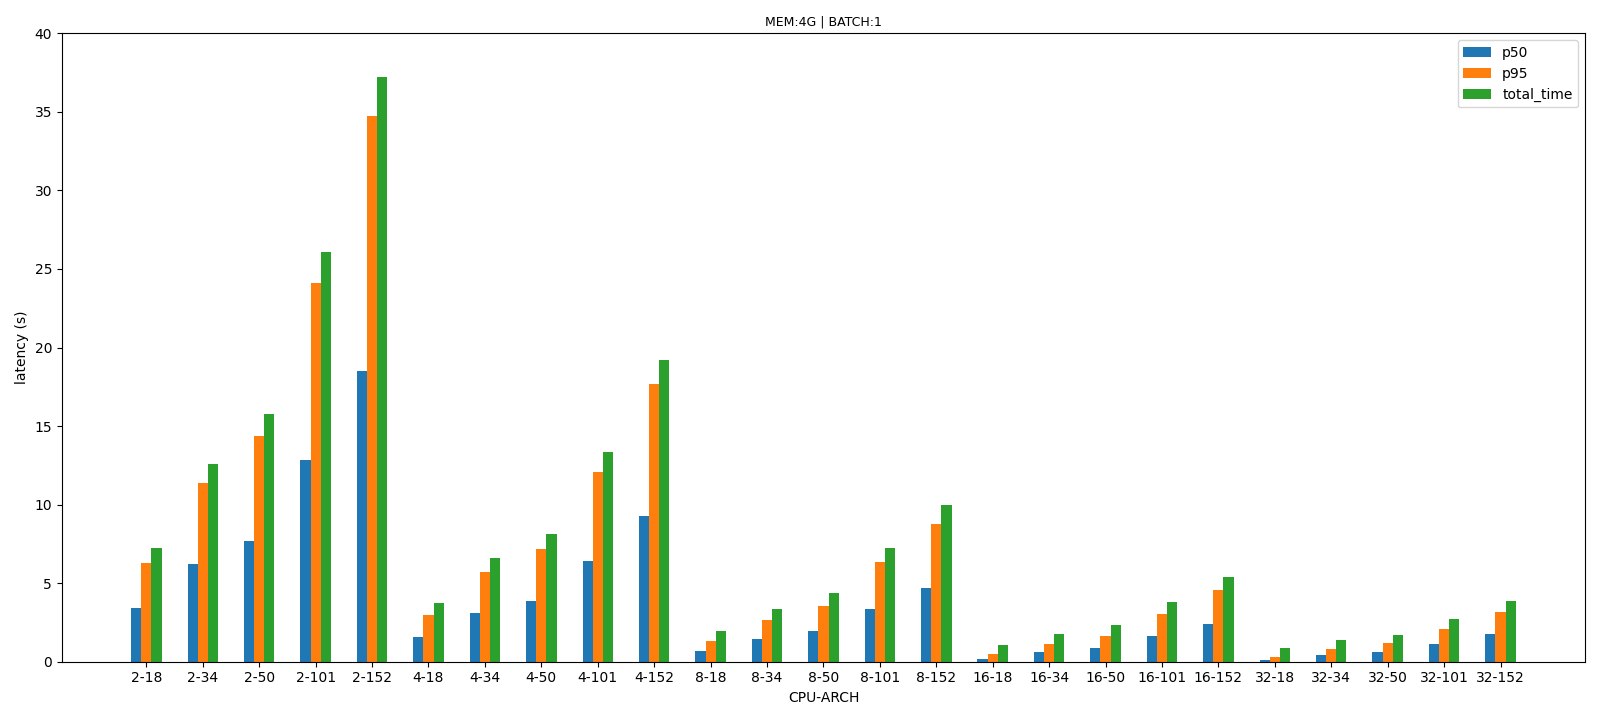

The figure above is from static experiment #5, where batching is disabled, inter_op is CPU# and intra_op is 1, all because of the previous findings


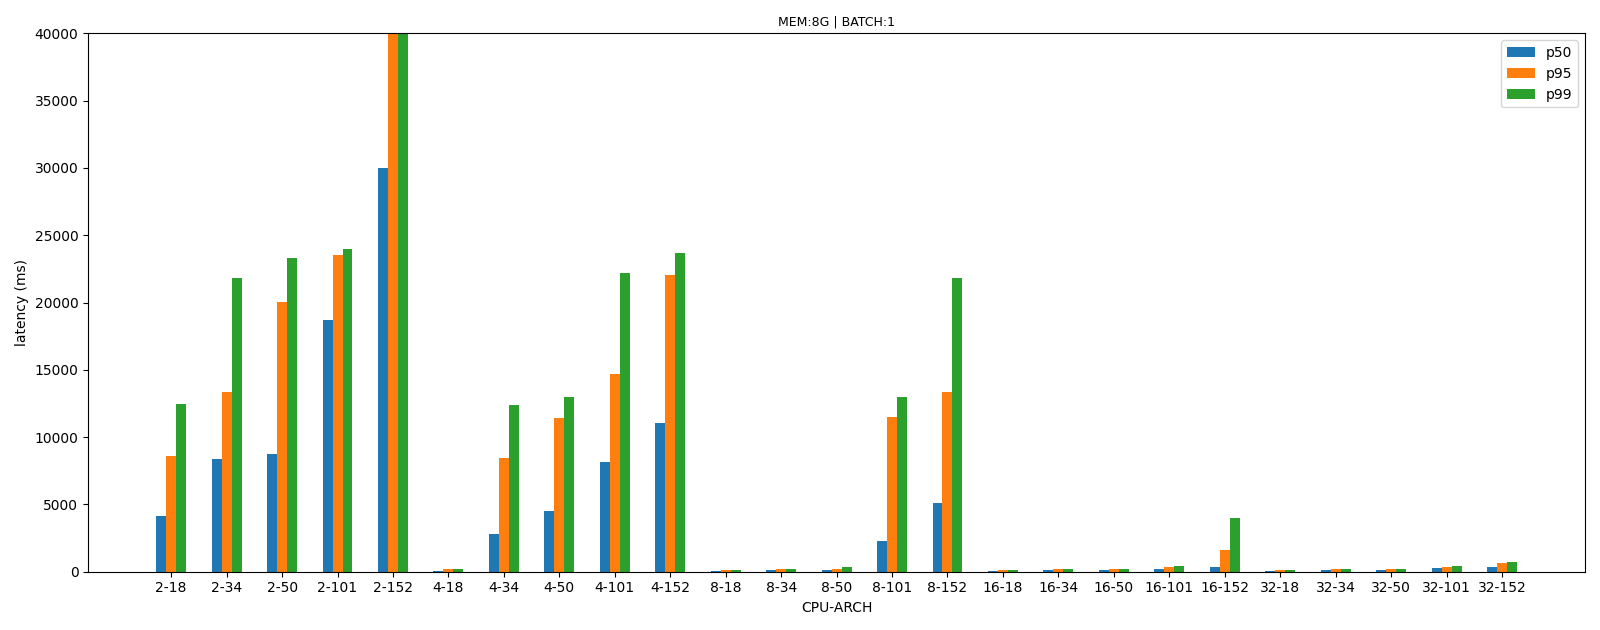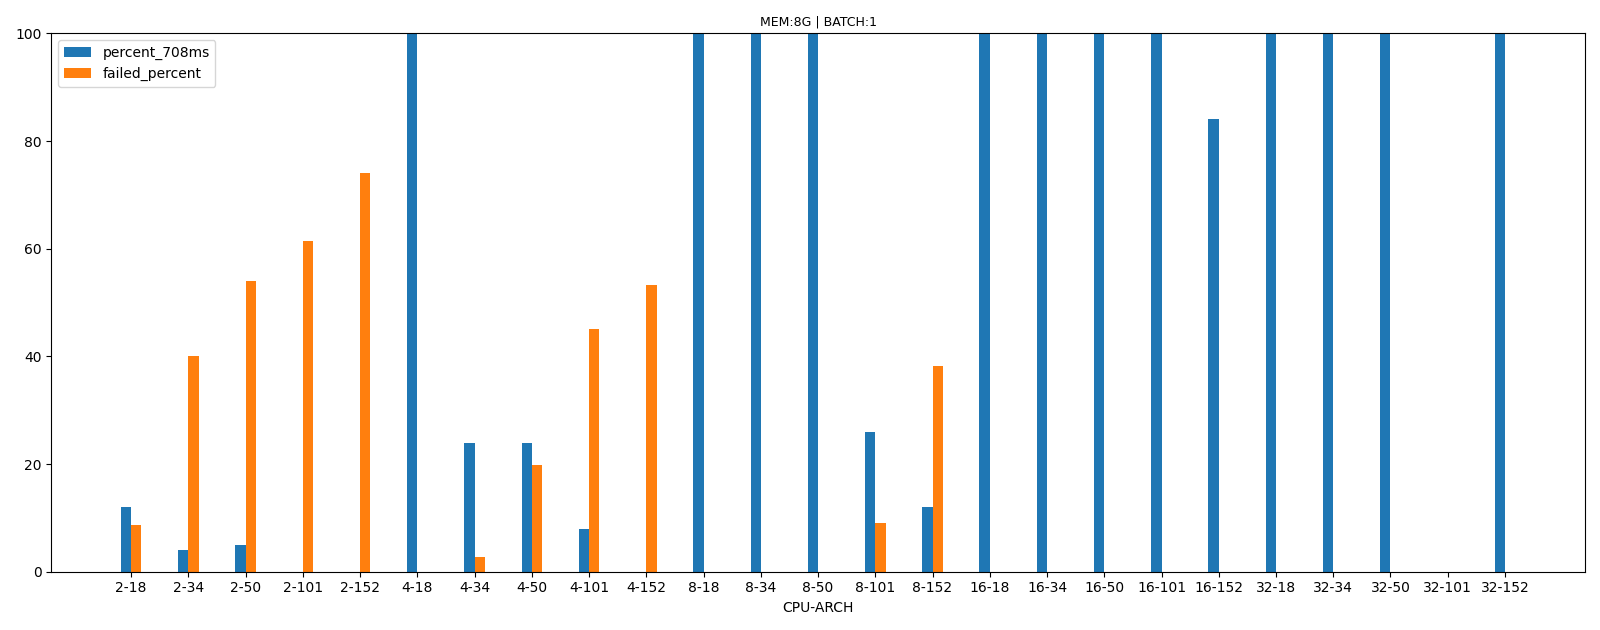

The figure above is from dynamic experiment #3, where batching is disabled, inter_op is CPU# and intra_op is 1, all because of the previous findings. workload used in this experiment is shown in bellow figure.

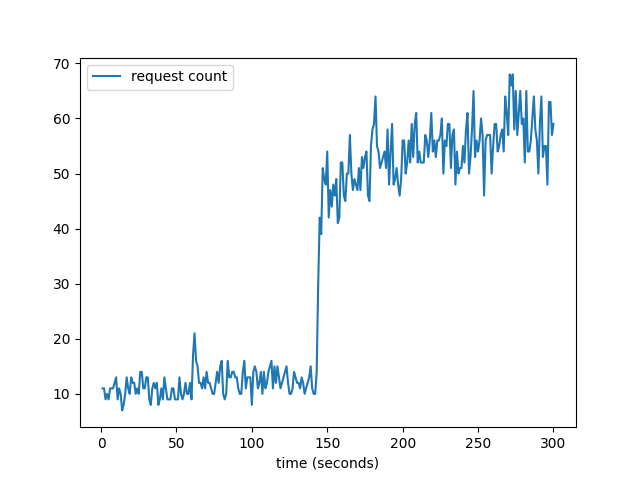



---


**Batch vs No Batch experiment**

- In the batch experiment, inputs of different batch sizes (1, 2, 4, 8, 16, 32, 64) are created client side and are sent to the server one by one (each request being repeated 40 times) and response time percentile_99 of these repeats is recorded for each batch size.

- In the no batch experiment, different loads (1, 2, 4, 8, 16, 32, 64) are sent to the server concurrently (for example, when load is selected as 8, 8 requests are sent to the server at the same time). For each load, the experiment gets repeated 40 times and p99 of response times is captured client side.


In [ ]:
results_path_no_batch = f"no_batch_result_Aug_26.csv"  # Every time, upload the file
results_path_batch = f"batch_result_Aug_26.csv"
df_no_batch = pd.read_csv(results_path_no_batch)
df_batch = pd.read_csv(results_path_batch)
dropping_columns = ["timestamp"]
df_no_batch = df_no_batch.drop(dropping_columns, axis=1)
df_batch = df_batch.drop(dropping_columns, axis=1)
df_no_batch.columns

Index(['CPU', 'MEM', 'ARCH', 'INTER_OP_PARALLELISM', 'INTRA_OP_PARALLELISM',
       'BATCH', 'p99', 'avg', 'min', 'max'],
      dtype='object')

In [ ]:
cpu = 16
arch = 152
df1_no_batch = df_no_batch[(df_no_batch[ParamTypes.CPU] == cpu) & (df_no_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
df1_batch = df_batch[(df_batch[ParamTypes.CPU] == cpu) & (df_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
width = 0.2
ax_no_batch = axes[0]
ax_batch = axes[1]

ax_no_batch.set_title(f"no batch | CPU={cpu} | ARCH={arch}")
ax_batch.set_title(f"batch | CPU={cpu} | ARCH={arch}")
ax_no_batch.set_xlabel("load")
ax_batch.set_xlabel("batch")
for ax in axes:
  ax.set_ylabel("p99 latency (s)")
groups_no_batch = df1_no_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
groups_batch = df1_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
x_keys = list(df1_no_batch[ParamTypes.BATCH].unique())
x = np.arange(len(x_keys))
for name, group in groups_no_batch:
  ax_no_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for name, group in groups_batch:
  ax_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for ax in axes:
  ax.set_xticks(x)
  ax.set_xticklabels(x_keys)
  ax.set_ylim([0, 15])
  ax.legend()
plt.show()
plt.close()

In [ ]:
cpu = 4
arch = 18
df2_no_batch = df_no_batch[(df_no_batch[ParamTypes.CPU] == cpu) & (df_no_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
df2_batch = df_batch[(df_batch[ParamTypes.CPU] == cpu) & (df_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
width = 0.2
ax_no_batch = axes[0]
ax_batch = axes[1]

ax_no_batch.set_title(f"no batch | CPU={cpu} | ARCH={arch}")
ax_batch.set_title(f"batch | CPU={cpu} | ARCH={arch}")
ax_no_batch.set_xlabel("load")
ax_batch.set_xlabel("batch")
for ax in axes:
  ax.set_ylabel("p99 latency (s)")
groups_no_batch = df2_no_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
groups_batch = df2_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
x_keys = list(df2_no_batch[ParamTypes.BATCH].unique())
x = np.arange(len(x_keys))
for name, group in groups_no_batch:
  ax_no_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for name, group in groups_batch:
  ax_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for ax in axes:
  ax.set_xticks(x)
  ax.set_xticklabels(x_keys)
  ax.set_ylim([0, 4])
  ax.legend()
plt.show()
plt.close()



---


**Batch vs No Batch experiment on GPU**

In [ ]:
results_path_no_batch = f"no_batch_result_gpu_Sep_10.csv"  # Every time, upload the file
results_path_batch = f"batch_result_gpu_Sep_10.csv"
df_no_batch = pd.read_csv(results_path_no_batch)
df_batch = pd.read_csv(results_path_batch)
dropping_columns = ["timestamp"]
df_no_batch = df_no_batch.drop(dropping_columns, axis=1)
df_batch = df_batch.drop(dropping_columns, axis=1)
df_no_batch.columns

In [ ]:
cpu = 16
arch = 152
df1_no_batch = df_no_batch[(df_no_batch[ParamTypes.CPU] == cpu) & (df_no_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
df1_batch = df_batch[(df_batch[ParamTypes.CPU] == cpu) & (df_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
width = 0.2
ax_no_batch = axes[0]
ax_batch = axes[1]

ax_no_batch.set_title(f"GPU | no batch | CPU={cpu} | ARCH={arch}")
ax_batch.set_title(f"GPU | batch | CPU={cpu} | ARCH={arch}")
ax_no_batch.set_xlabel("load")
ax_batch.set_xlabel("batch")
for ax in axes:
  ax.set_ylabel("p99 latency (s)")
groups_no_batch = df1_no_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
groups_batch = df1_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
x_keys = list(df1_no_batch[ParamTypes.BATCH].unique())
x = np.arange(len(x_keys))
for name, group in groups_no_batch:
  ax_no_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for name, group in groups_batch:
  ax_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for ax in axes:
  ax.set_xticks(x)
  ax.set_xticklabels(x_keys)
  ax.set_ylim([0, 3])
  ax.legend()
plt.show()
plt.close()

In [ ]:
cpu = 2
arch = 18
df2_no_batch = df_no_batch[(df_no_batch[ParamTypes.CPU] == cpu) & (df_no_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
df2_batch = df_batch[(df_batch[ParamTypes.CPU] == cpu) & (df_batch[ParamTypes.MODEL_ARCHITECTURE] == arch)]
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
width = 0.2
ax_no_batch = axes[0]
ax_batch = axes[1]

ax_no_batch.set_title(f"GPU | no batch | CPU={cpu} | ARCH={arch}")
ax_batch.set_title(f"GPU | batch | CPU={cpu} | ARCH={arch}")
ax_no_batch.set_xlabel("load")
ax_batch.set_xlabel("batch")
for ax in axes:
  ax.set_ylabel("p99 latency (s)")
groups_no_batch = df2_no_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
groups_batch = df2_batch.groupby([ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM])
x_keys = list(df2_no_batch[ParamTypes.BATCH].unique())
x = np.arange(len(x_keys))
for name, group in groups_no_batch:
  ax_no_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for name, group in groups_batch:
  ax_batch.plot(x, group["p99"], label=f"inter, intra={str(name)}")
for ax in axes:
  ax.set_xticks(x)
  ax.set_xticklabels(x_keys)
  ax.set_ylim([0, 0.5])
  ax.legend()
plt.show()
plt.close()



---
**CPU VS GPU**

for this experiment:
- num_batch_threads is set to CPU#
- max_enqueued_batches is set to 1000000
- max_batch_latency is set to 10 ms
- hardware (CPU or GPU) is added to the configuration space


In [ ]:
results_path = f"load_result_Sep_10.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)

experiment_type = EXPERIMENT_TYPE_STATIC  # Set this based on experiment type

dropping_columns = [ParamTypes.REPLICA, "timestamp", ParamTypes.BATCH_TIMEOUT, "total"]

df = df.drop(dropping_columns, axis=1)
df.columns

Index(['CPU', 'MEM', 'BATCH', 'HARDWARE', 'ARCH', 'INTRA_OP_PARALLELISM',
       'INTER_OP_PARALLELISM', 'NUM_BATCH_THREADS', 'MAX_ENQUEUED_BATCHES',
       'total_time', 'avg', 'min', 'max', 'p50', 'p95', 'p99'],
      dtype='object')



---


**First we check wether main memory size has any impact on the quality of models on GPU.**


---



In [ ]:

dfs = {
    "cpu:16-batch:64-arch:18-intra:1-inter:16": df[
      (df[ParamTypes.CPU] == 16) & 
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.INTRA_OP_PARALLELISM] == 1) &
      (df[ParamTypes.INTER_OP_PARALLELISM] == 16) &
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-batch:8-arch:152-intra:4-inter:4": df[
      (df[ParamTypes.CPU] == 4) & 
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.INTRA_OP_PARALLELISM] == 4) &
      (df[ParamTypes.INTER_OP_PARALLELISM] == 4) &
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-batch:1-arch:152-intra:1-inter:4": df[
      (df[ParamTypes.CPU] == 4) & 
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.INTRA_OP_PARALLELISM] == 1) &
      (df[ParamTypes.INTER_OP_PARALLELISM] == 4) &
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
}
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plt.suptitle("Main Memory Impact on GPU")
width = 0.2
for i, ax in enumerate(axes):
    ax.set_xlabel("memory")
    ax.set_ylabel("latency (s)")
    df_mem = list(dfs.values())[i]
    ax.set_title(list(dfs.keys())[i])
    x = np.arange(len(list(df_mem.iterrows())))
    values = []
    x_keys = []
    for _, row in df_mem.iterrows():
      values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
      x_keys.append(row[ParamTypes.MEMORY])
    rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
    rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
    rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_ylim(0, 30)
    ax.legend()
plt.show()
plt.close()



---

**Now we want to see wether parallelism thread pools affect the latency of our models on CPU and GPU (We previously saw their impact on CPU)**

---



In [ ]:
dfs = {
    "cpu:4-memory:8G-batch:1-arch:152-hardware:cpu": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "cpu")
    ],
    "cpu:4-memory:8G-batch:1-arch:152-hardware:gpu": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
}
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plt.suptitle("Parallelism Impact")
width = 0.2
for i, ax in enumerate(axes):
    ax.set_xlabel("intra_op - inter_op")
    ax.set_ylabel("latency (s)")
    df_parallelism = list(dfs.values())[i]
    ax.set_title(list(dfs.keys())[i])
    x = np.arange(len(list(df_parallelism.iterrows())))
    values = []
    x_keys = []p
    for _, row in df_parallelism.iterrows():
      values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
      x_keys.append(f"{row[ParamTypes.INTRA_OP_PARALLELISM]} - {row[ParamTypes.INTER_OP_PARALLELISM]}")
    rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
    rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
    rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_ylim(0, 11)
    ax.legend()
plt.show()
plt.close()



---

**Now let's see batching impact on model when we use hardware accelerator (GPU) for the services. (We previously saw batching impact on CPU nodes)**

---



In [ ]:
dfs = {
    "cpu:4-memory:8G-batch:1-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:8-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:64-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:1-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:8-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:64-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
}
fig, axes = plt.subplots(2, 3, figsize=(18, 11))

plt.suptitle("Batch Impact")
width = 0.2
idx = 0
for i, axs in enumerate(axes):
    for ax in axs:
      ax.set_xlabel("intra_op - inter_op")
      ax.set_ylabel("latency (s)")
      df_parallelism = list(dfs.values())[idx]
      ax.set_title(list(dfs.keys())[idx])
      x = np.arange(len(list(df_parallelism.iterrows())))
      values = []
      x_keys = []
      for _, row in df_parallelism.iterrows():
        values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
        x_keys.append(f"{row[ParamTypes.INTRA_OP_PARALLELISM]} - {row[ParamTypes.INTER_OP_PARALLELISM]}")
      rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
      rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
      rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
      ax.set_xticks(x)
      ax.set_xticklabels(x_keys)
      ax.set_ylim(0, 5)
      ax.legend()
      idx += 1
plt.show()
plt.close()



---

**How much CPU# matters when models run on GPU?**

---



In [ ]:
dfs = {
    "cpu:4-memory:8G-batch:1-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:64-arch:18": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:1-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:4-memory:8G-batch:64-arch:152": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:16-memory:8G-batch:1-arch:18": df[
      (df[ParamTypes.CPU] == 16) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:16-memory:8G-batch:64-arch:18": df[
      (df[ParamTypes.CPU] == 16) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 18) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:16-memory:8G-batch:1-arch:152": df[
      (df[ParamTypes.CPU] == 16) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
    "cpu:16-memory:8G-batch:64-arch:152": df[
      (df[ParamTypes.CPU] == 16) &
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 152) & 
      (df[ParamTypes.HARDWARE] == "gpu")
    ],
}
fig, axes = plt.subplots(2, 4, figsize=(18, 11))

plt.suptitle("Batch Impact")
width = 0.2
idx = 0
for i, axs in enumerate(axes):
    for ax in axs:
      ax.set_xlabel("intra_op - inter_op")
      ax.set_ylabel("latency (s)")
      df_parallelism = list(dfs.values())[idx]
      ax.set_title(list(dfs.keys())[idx])
      x = np.arange(len(list(df_parallelism.iterrows())))
      values = []
      x_keys = []
      for _, row in df_parallelism.sort_values(by=[ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM]).iterrows():
        values.append({"p50": row["p50"], "p95": row["p95"], "p99": row["p99"]})
        x_keys.append(f"{row[ParamTypes.INTRA_OP_PARALLELISM]} - {row[ParamTypes.INTER_OP_PARALLELISM]}")
      rects1 = ax.bar(x-width, list(map(lambda x:x["p50"], values)), width, label='p50')
      rects2 = ax.bar(x, list(map(lambda x:x["p95"], values)), width, label="p95")
      rects3 = ax.bar(x+width, list(map(lambda x:x["p99"], values)), width, label='p99')
      ax.set_xticks(x)
      ax.set_xticklabels(x_keys)
      ax.set_ylim(0, 10)
      ax.legend()
      idx += 1
plt.show()
plt.close()



---

###Throughput Experiment

for this experiment:
- model: resnet18 to resnet152
- cpu size: one of {4, 8, 16}
- memory size: f"{cpu#}G"
- num_batch_threads: one of {1, 2, cpu#}
- max_enqueued_batches: 1000000
- hardware: CPU or GPU

In [ ]:
results_path = f"throughput_result_CPU_Sep_21.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)

experiment_type = EXPERIMENT_TYPE_STATIC  # Set this based on experiment type

dropping_columns = [ParamTypes.REPLICA, "timestamp"]

df = df.drop(dropping_columns, axis=1)
df.columns
# df[["client_count", "server_count"]]

In [ ]:
df = df[(df[ParamTypes.NUM_BATCH_THREADS] == df[ParamTypes.CPU])]
dfs = {
    "hardware:CPU-batch:1-CPU:4-lambda:10": df[
      (df[ParamTypes.MEMORY] == "4G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:8-CPU:4-lambda:10": df[
      (df[ParamTypes.MEMORY] == "4G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:64-CPU:4-lambda:10": df[
      (df[ParamTypes.MEMORY] == "4G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:1-CPU:8-lambda:10": df[
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:8-CPU:8-lambda:10": df[
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:64-CPU:8-lambda:10": df[
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:1-CPU:16-lambda:10": df[
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:8-CPU:16-lambda:10": df[
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:64-CPU:16-lambda:10": df[
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 10)
    ],
    "hardware:CPU-batch:1-CPU:4-lambda:100": df[
      (df[ParamTypes.MEMORY] == "4G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:8-CPU:4-lambda:100": df[
      (df[ParamTypes.MEMORY] == "4G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:64-CPU:4-lambda:100": df[
      (df[ParamTypes.MEMORY] == "4G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:1-CPU:8-lambda:100": df[
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:8-CPU:8-lambda:100": df[
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:64-CPU:8-lambda:100": df[
      (df[ParamTypes.MEMORY] == "8G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:1-CPU:16-lambda:100": df[
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:8-CPU:16-lambda:100": df[
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
    "hardware:CPU-batch:64-CPU:16-lambda:100": df[
      (df[ParamTypes.MEMORY] == "16G") &
      (df[ParamTypes.BATCH] == 64) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["lambda"] == 100)
    ],
}
fig, axes = plt.subplots(6, 3, figsize=(22, 22))

width = 0.2
idx = 0
for i, axs in enumerate(axes):
    for ax in axs:
      ax2 = ax.twinx()
      ax.set_xlabel("intra_op - inter_op")
      ax.set_ylabel("throughput (rps)", color="b")
      ax2.set_ylabel("p99 latency (s)", color="g")
      df_parallelism = list(dfs.values())[idx]
      ax.set_title(f"{list(dfs.keys())[idx]}")
      x = np.arange(len(list(df_parallelism.iterrows())))
      values = []
      x_keys = []
      for _, row in df_parallelism.iterrows():
        values.append(
            {
              "throughput": row["rate"],
              "p99": round(row["p99_latency"] / 1000, 2),
              "p99_q": round(row["p99_queueing"] / 1000, 2)
            }
        )
        x_keys.append(f"{row[ParamTypes.INTRA_OP_PARALLELISM]}|{row[ParamTypes.INTER_OP_PARALLELISM]}")
      rects1 = ax.bar(x-width-width/4, list(map(lambda x:x["throughput"], values)), width, color="b")
      rects2 = ax2.bar(x, list(map(lambda x: x["p99"], values)), width, color="g")
      rects3 = ax2.bar(x+width+width/4, list(map(lambda x: x["p99_q"], values)), width, color="y")
      ax.set_xticks(x)
      ax.set_xticklabels(x_keys)
      if i < 3:
        ax.set_ylim(0, 11)
        ax2.set_ylim(0, 1)
      else:
        ax.set_ylim(0, 110)
      # ax.legend()
        ax2.set_ylim(0, 13)
      idx += 1
fig.tight_layout()
plt.show()
plt.close()



---


###Experiment with multiple poisson lambdas

- CPU: 8
- model: resnet50
- num_batch_threads: 8
- memory: 8G
- batch: {1, 8, 64}
- intra_op: {1, cpu#}
- inter_op: {1, cpu#}
- lambda: {40, 50, 60, 70, 80, 90, 100}

In [ ]:
results_path = f"throughput_result_Oct_6.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = [ParamTypes.REPLICA, "timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
tp_min = df["rate"].min()
tp_max = df["rate"].max()
df.columns
df_for_print = df[df["BATCH"] == 1]
df_for_print = df_for_print.drop(["CPU", "MEM", "ARCH", "p99_queueing", "HARDWARE", "BATCH", "1/avg_latency", "server_count"], axis=1)
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print

,intra_op,inter_op,lambda,percent_708ms,average_latency,p99_latency,rate,client_count,duration
0,1,8,40,1.00,102.84,208.02,39.14,4869,124.78
1,1,8,50,1.00,101.61,206.10,47.27,5960,126.01
2,1,8,60,1.00,101.62,209.41,57.06,7253,126.78
3,1,8,70,1.00,107.35,258.74,64.44,8259,127.99
4,1,8,80,0.99,168.98,698.12,74.95,9673,129.14
5,1,8,90,0.50,1110.31,6653.60,80.17,10783,134.59
6,1,8,100,0.38,1194.02,4024.98,80.66,11950,148.28
7,8,1,40,0.00,5216.16,7400.74,18.82,4778,253.95
8,8,1,50,0.00,5211.85,7400.65,18.98,6057,319.25
9,8,1,60,0.00,5075.44,7399.25,19.50,7275,373.11


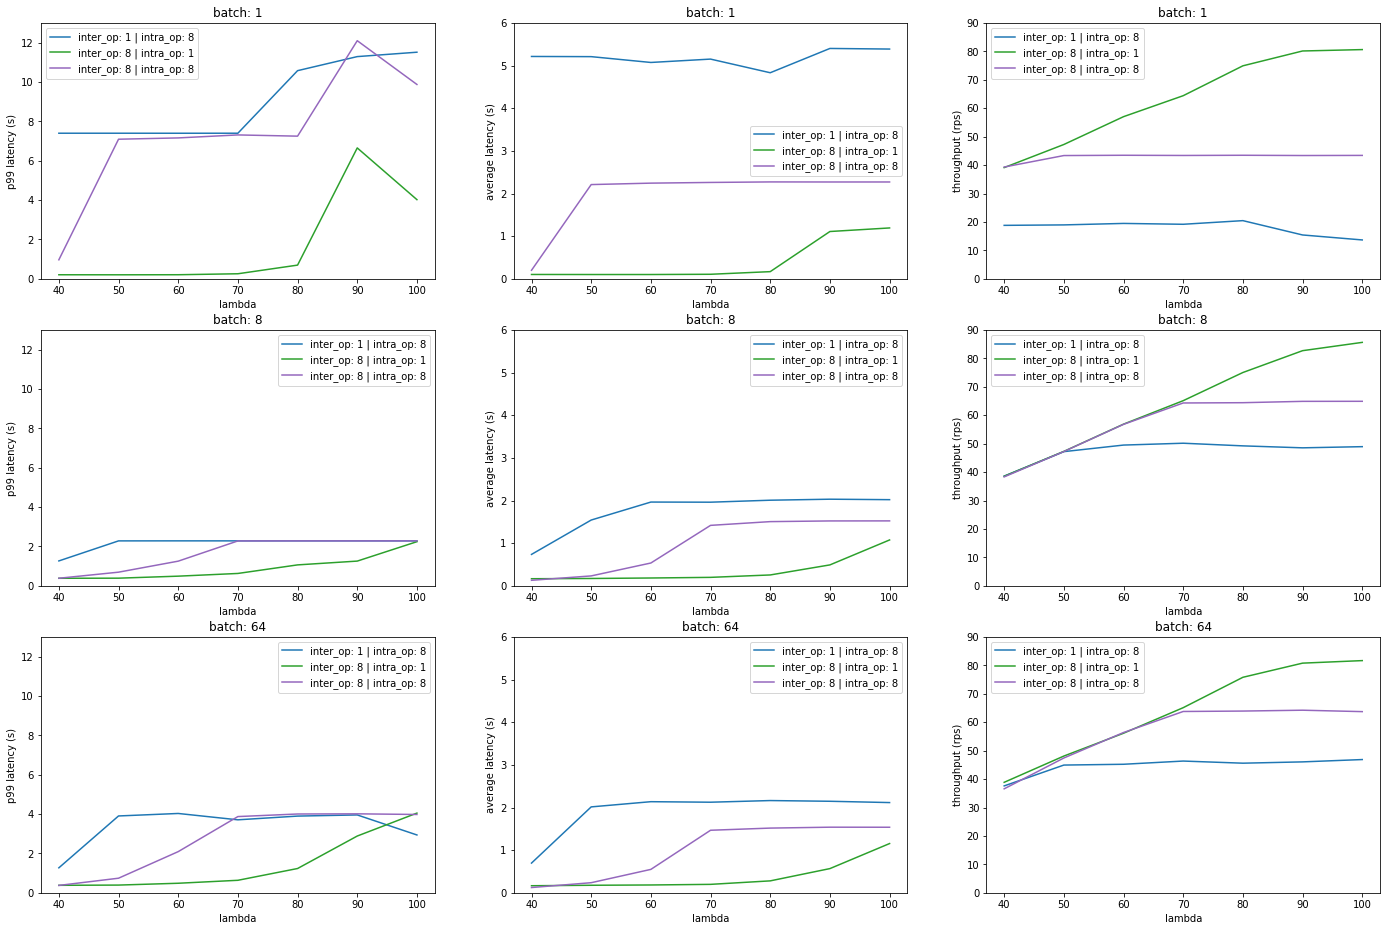

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(24, 16))
x_keys = list(df["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2
dfg = list(df.groupby([ParamTypes.BATCH, ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM]))
idx = 0
for i, axs in enumerate(axes):
  for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_xlabel("lambda")
    
    groups = dfg[i*3:i*3 + 3]
    for config, group in groups:
      group["server_count"] = group["server_count"].diff().fillna(list(group["server_count"])[0])
      if idx == 0:
        ax.set_ylabel("p99 latency (s)")
        p1 = ax.plot(x, list(map(lambda x: x / 1000, group["p99_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[2]}")
        ax.set_ylim(0, 13)
      elif idx == 1:
        ax.set_ylabel("average latency (s)")
        p2 = ax.plot(x, list(map(lambda x: x / 1000, group["average_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[2]}")
        ax.set_ylim(0, 6)
      else:
        ax.set_ylabel("throughput (rps)")
        p3 = ax.plot(x, group["rate"], width, label=f"inter_op: {config[1]} | intra_op: {config[2]}")
        # p3 = ax2.plot(x, list(map(lambda tup: tup[0] / tup[1], list(zip(group["server_count"], group["duration"])))), width, color="r")
        ax.set_ylim(0, 90)
    
    ax.set_title(f"batch: {config[0]}")
    
    legend_without_duplicate_labels(ax)
    # ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    idx += 1
    idx = idx % 3
# fig.tight_layout()
plt.show()
plt.close()



---


###Experiment with multiple poisson lambdas

- CPU: 8
- model: resnet50
- num_batch_threads: 8
- memory: 8G
- batch: {1, 8, 64}
- (intra_op, inter_op): {(1, 1), (1, 8), (8, 1), (2, 4), (2, 8), (4, 2), (4, 4), (8, 2)}
- lambda: {20, 40, 60, 80, 100, 120}

In [ ]:
results_path = f"throughput_result_Oct_18.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = [ParamTypes.REPLICA, "timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
tp_min = df["rate"].min()
tp_max = df["rate"].max()
df.columns
df_for_print = df[df["BATCH"] == 1]
df_for_print = df_for_print.drop(["CPU", "MEM", "ARCH", "p99_queueing", "HARDWARE", "BATCH", "1/avg_latency"], axis=1)
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print

,intra_op,inter_op,lambda,percent_708ms,average_latency,p99_latency,rate,client_count,success_count,duration,server_count,cpu_rate,cpu_throt,mem_util
0,1,1,20,0.00,8213.11,13318.76,11.43,2409,2409,211.05,2409.0,1.06,0.00,389.02
1,1,1,40,0.00,8540.22,13321.75,11.39,4924,4820,426.50,4853.0,1.05,0.00,390.65
2,1,1,60,0.00,8530.36,13321.78,10.07,7235,4287,429.30,NaN,1.00,0.00,444.94
3,1,1,80,0.00,9319.81,22544.86,6.32,9511,2604,431.27,NaN,1.05,0.00,481.69
4,1,1,100,0.00,9130.50,22587.57,6.09,12014,2540,435.27,NaN,1.05,0.00,490.67
5,1,1,120,0.00,9387.88,22679.25,5.70,14192,2378,436.31,NaN,1.05,0.00,495.55
6,1,8,20,1.00,119.98,216.35,19.88,2429,2429,122.81,2424.0,2.68,0.00,578.75
7,1,8,40,1.00,110.35,213.46,38.47,4889,4889,126.88,4894.0,4.60,0.00,578.75
8,1,8,60,1.00,111.41,217.00,56.87,7241,7241,127.55,7241.0,5.47,0.02,388.96
9,1,8,80,0.88,368.12,1950.95,73.16,9508,9508,130.16,9508.0,7.96,0.27,406.52


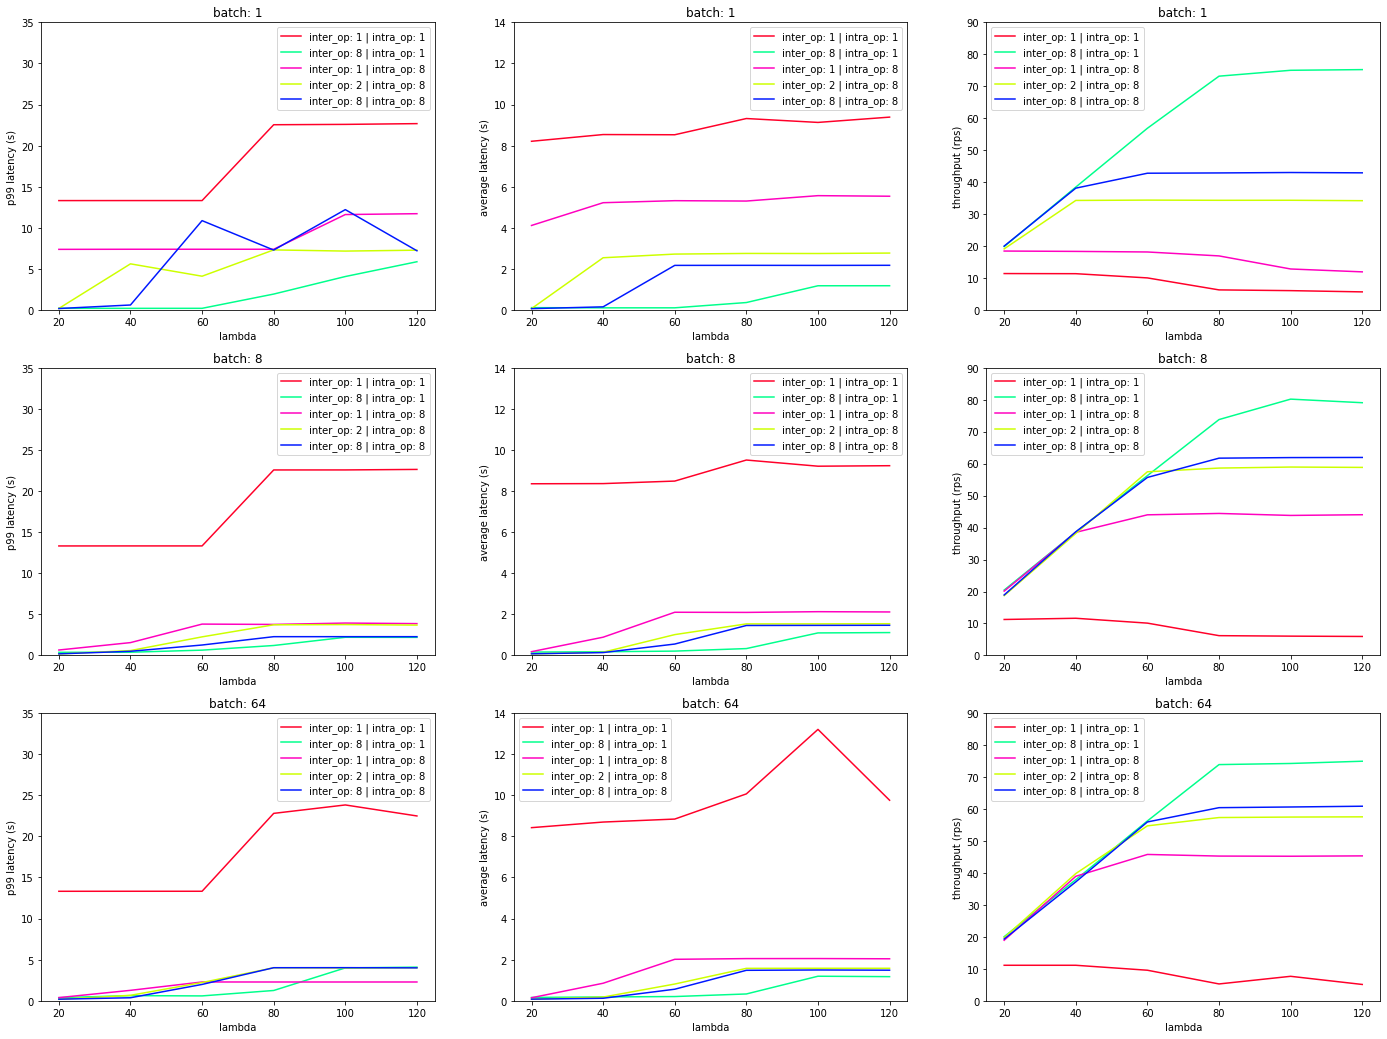

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
x_keys = list(df["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2

df = df[df[ParamTypes.INTRA_OP_PARALLELISM].isin([1, 8])]

dfg = list(df.groupby([ParamTypes.BATCH]))
NUM_COLORS = len(dfg[0][1].groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM]))
idx = 0
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
for i, axs in enumerate(axes):
  batchsize, df_batch = dfg[i]
  groups = df_batch.groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM])
  for ax in axs:
    ax.set_prop_cycle(color=[scalarMap.to_rgba(k) for k in range(len(groups))])
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_xlabel("lambda")
    for config, group in groups:
      
      if idx == 0:
        ax.set_ylabel("p99 latency (s)")
        p1 = ax.plot(x, list(map(lambda x: x / 1000, group["p99_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
        ax.set_ylim(0, 35)
      elif idx == 1:
        ax.set_ylabel("average latency (s)")
        p2 = ax.plot(x, list(map(lambda x: x / 1000, group["average_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
        ax.set_ylim(0, 14)
      else:
        ax.set_ylabel("throughput (rps)")
        p3 = ax.plot(x, group["rate"], width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
        # p3 = ax2.plot(x, list(map(lambda tup: tup[0] / tup[1], list(zip(group["server_count"], group["duration"])))), width, color="r")
        ax.set_ylim(0, 90)
    
    ax.set_title(f"batch: {batchsize}")
    
    legend_without_duplicate_labels(ax)
    # ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    idx += 1
    idx = idx % 3
    
# fig.tight_layout()
plt.show()
plt.close()



---


###Experiment with multiple poisson lambdas

- (CPU, Replica): {(8, 1), (4, 2), (2, 4), (1, 8)}
- model: resnet50
- num_batch_threads: CPU#
- memory: 8G
- batch: {1, 8, 32}
- (intra_op, inter_op): {(1, CPU#), (CPU#, 1), (CPU#, CPU#)}
- lambda: {40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90}

In [ ]:
results_path = f"throughput_result_Oct_28.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
tp_min = df["rate"].min()
tp_max = df["rate"].max()
df.columns
df_for_print = df[(df["BATCH"] == 32)]
df_for_print = df_for_print.drop(["MEM", "ARCH", "p99_queueing", "HARDWARE", "BATCH", "1/avg_latency"], axis=1)
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(24, 22))
x_keys = list(df["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2

dfg = list(df.groupby([ParamTypes.REPLICA, ParamTypes.CPU]))
for i, axs in enumerate(axes):
  j = 0
  size, df_size = dfg[i]
  groups_batch = list(df_size.groupby([ParamTypes.BATCH]))
  for ax in axs:
    batchsize, df_batch = groups_batch[j]
    groups = df_batch.groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM])
    j += 1
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_xlabel("lambda")
    ax.set_ylabel("p99 latency (s)")
    for config, group in groups:
      p1 = ax.plot(x, list(map(lambda x: x / 1000, group["p99_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
    ax.plot(x, [0.75 for _ in range(len(x))], width, label="0.75", color="r", linestyle="dashed")
    ax.set_ylim(0, 15)

    
    ax.set_title(f"(replicas, cpu#): {size} | batch: {batchsize}")
    
    legend_without_duplicate_labels(ax)
    # ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    
# fig.tight_layout()
plt.show()
plt.close()

In [ ]:
results_path = f"throughput_result_Nov_9.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
tp_min = df["rate"].min()
tp_max = df["rate"].max()
df.columns
df_for_print = df[(df["BATCH"] == 1) & (df['INTRA_OP_PARALLELISM'] == 1)]
df_for_print = df_for_print.drop(["MEM", "ARCH", "p99_queueing", "HARDWARE", "BATCH", "1/avg_latency"], axis=1)
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(24, 22))
x_keys = list(df["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2

dfg = list(df.groupby([ParamTypes.REPLICA, ParamTypes.CPU]))
for i, axs in enumerate(axes):
  j = 0
  size, df_size = dfg[i]
  groups_batch = list(df_size.groupby([ParamTypes.BATCH]))
  groups_batch_1 = groups_batch[0]
  groups_batch_8 = groups_batch[1]
    
  for ax in axs:
    if j < 2:
      groups_batch_selected = groups_batch_1
    else:
      groups_batch_selected = groups_batch_8
    batchsize, df_batch = groups_batch_selected
    groups = df_batch.groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM])
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_xlabel("lambda")
    if j % 2 == 0:
      ax.set_ylabel("p99 latency (s)")
      ax.set_ylim(0, 13)
    else:
      ax.set_ylabel("throughput (rps)")
      ax.set_ylim(0, 85)
    for config, group in groups:
      if j % 2 == 0:
        p1 = ax.plot(x, list(map(lambda x: x / 1000, group["p99_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
        # p2 = ax.plot(x, list(map(lambda x: x / 1000, group["p99_queueing"])), width, label=f"queueing: inter_op: {config[1]} | intra_op: {config[0]}")
      else:
        p1 = ax.plot(x, list(group["rate"]), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
    if j % 2 == 0:
      ax.plot(x, [0.75 for _ in range(len(x))], width, label="750 ms", color="r", linestyle="dashed")
    
    j += 1

    
    ax.set_title(f"(replicas, cpu#): {size} | batch: {batchsize}")
    
    legend_without_duplicate_labels(ax)
    # ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    
# fig.tight_layout()
plt.show()
plt.close()



---


###Experiment with multiple poisson lambdas for `model version`

- CPU: 8
- model: {resnet18, resnet34, resnet50, resnet101, resnet152}
- num_batch_threads: CPU#
- memory: 8G
- batch: 1
- (intra_op, inter_op): (1, CPU#)
- lambda: {10, 30, 50, 70, 90, 110, 130}

In [ ]:
results_path = f"throughput_result_model_version_Oct_29.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
tp_min = df["rate"].min()
tp_max = df["rate"].max()
df.columns
df_for_print = df[(df["BATCH"] == 1)]
df_for_print = df_for_print.drop(["MEM", "p99_queueing", "HARDWARE", "BATCH", "1/avg_latency", "REPLICA", ParamTypes.INTER_OP_PARALLELISM, ParamTypes.INTRA_OP_PARALLELISM], axis=1)
df_for_print



---

- arch: resnet50
- cpu: 8


In [ ]:
results_path = f"throughput_result_Nov_19.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
tp_min = df["rate"].min()
tp_max = df["rate"].max()
df.columns
df_for_print = df[(df["BATCH"] == 1)]
df_for_print = df_for_print.drop(["CPU", "MEM", "ARCH", "p99_queueing", "HARDWARE", "BATCH", "1/avg_latency", "REPLICA"], axis=1)
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(24, 11))
x_keys = list(df["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2

groups_batch = list(df.groupby([ParamTypes.BATCH]))
for i, axs in enumerate(axes):
  batch, df_batch = groups_batch[i]
  groups = df_batch.groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM])
  for config, group in groups:
    for j in range(3):
      ax = axs[j]
      ax.set_xticks(x)
      ax.set_xticklabels(x_keys)
      ax.set_xlabel("lambda")
      ax.set_title(f"batch = {batch}")
      if j == 0:
        ax.set_ylabel("average latency (s)")
        ax.set_ylim(0, 6)
        p1 = ax.plot(x, list(map(lambda x: x / 1000, group["average_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
      elif j == 1:
        ax.set_ylabel("p99 latency (s)")
        ax.set_ylim(0, 22)
        p1 = ax.plot(x, list(map(lambda x: x / 1000, group["p99_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
      else:
        ax.set_ylabel("throughput (rps)")
        ax.set_ylim(0, 85)
        p1 = ax.plot(x, list(group["rate"]), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")    
      legend_without_duplicate_labels(ax)
    
# fig.tight_layout()
plt.show()
plt.close()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))
x_keys = list(df["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2

dfg = df.groupby([ParamTypes.MODEL_ARCHITECTURE])
for ax in axs:
  ax.set_xticks(x)
  ax.set_xticklabels(x_keys)
  ax.set_xlabel("lambda")

axs[0].set_ylabel("p99 latency (s)")
axs[1].set_ylabel("rate (rps)")
for model_arch, df_ma in dfg:
  axs[0].plot(x, list(map(lambda x: x / 1000, df_ma["p99_latency"])), width, label=f"resnet{model_arch}")
  axs[1].plot(x, list(map(lambda x: x, df_ma["rate"])), width, label=f"resnet{model_arch}")
  # plt.set_ylim(0, 15)  

legend_without_duplicate_labels(axs[0])
legend_without_duplicate_labels(axs[1])
# fig.tight_layout()
plt.show()
plt.close()





---

##Partitioned twitter trace workload

- on CPU
- MAX_ENQUEUED_BATCHES: 1000000
- NUM_BATCH_THREADS: CPU#
- memory: 8G

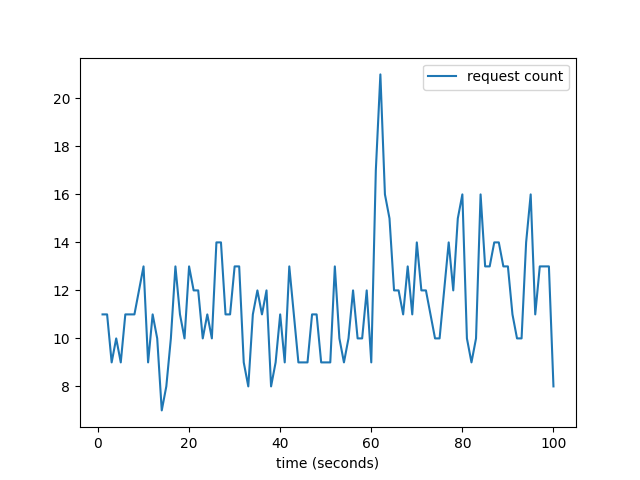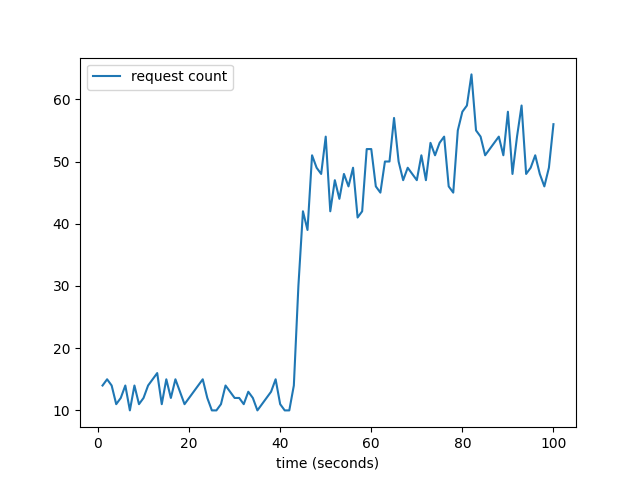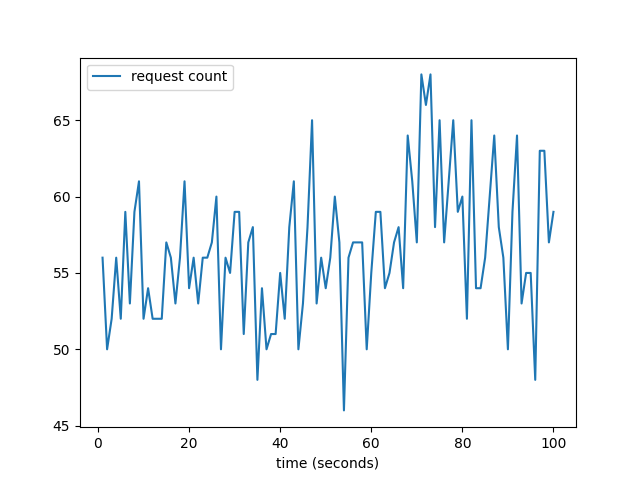

In [ ]:
results_path = f"experiment_result_Sep_25.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)

dropping_columns = [
    # ParamTypes.REPLICA,
    "timestamp",
    #  ParamTypes.BATCH_TIMEOUT,
    # ParamTypes.HARDWARE,
    # ParamTypes.NUM_BATCH_THREADS,
    # ParamTypes.MEMORY,
    # ParamTypes.MAX_ENQUEUED_BATCHES
]
df = df.drop(dropping_columns, axis=1)
df.columns


Index(['CPU', 'MEM', 'REPLICA', 'BATCH', 'BATCH_TIMEOUT', 'HARDWARE', 'ARCH',
       'INTRA_OP_PARALLELISM', 'INTER_OP_PARALLELISM', 'NUM_BATCH_THREADS',
       'MAX_ENQUEUED_BATCHES', 'percent_708ms', 'p50', 'p95', 'p99', 'qd_p99',
       'avg_latency', 'rate', '1/avg_latency', 'failed', 'total', 'part'],
      dtype='object')

In [ ]:

dfs = {
    "cpu:4-batch:1-arch:50-part:0": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) & 
      (df["part"] == 0)
    ],
    "cpu:4-batch:8-arch:50-part:0": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 0)
    ],
    "cpu:4-batch:32-arch:50-part:0": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 32) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 0)
    ],
    "cpu:4-batch:1-arch:50-part:1": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 1)
    ],
    "cpu:4-batch:8-arch:50-part:1": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 1)
    ],
    "cpu:4-batch:32-arch:50-part:1": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 32) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 1)
    ],
    "cpu:4-batch:1-arch:50-part:2": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 1) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 2)
    ],
    "cpu:4-batch:8-arch:50-part:2": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 8) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 2)
    ],
    "cpu:4-batch:32-arch:50-part:2": df[
      (df[ParamTypes.CPU] == 4) &
      (df[ParamTypes.BATCH] == 32) &
      (df[ParamTypes.MODEL_ARCHITECTURE] == 50) &
      (df["part"] == 2)
    ],
}
fig, axes = plt.subplots(3, 3, figsize=(18, 11))

# plt.suptitle("Batch Impact")
width = 0.2
idx = 0
for i, axs in enumerate(axes):
    for ax in axs:
      ax2 = ax.twinx()
      ax.set_xlabel("intra_op - inter_op")
      ax.set_ylabel("throughput (rps)", color="b")
      ax2.set_ylabel("p99 latency (s)", color="g")
      df_parallelism = list(dfs.values())[idx]
      ax.set_title(f"{list(dfs.keys())[idx]}")
      x = np.arange(len(list(df_parallelism.iterrows())))
      values = []
      x_keys = []
      for _, row in df_parallelism.sort_values(by=[ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM]).iterrows():
        values.append(
            {
              "throughput": row["rate"],
              "percent_708ms": row["percent_708ms"],
              "p99": round(row["p99"] / 1000, 2),
            }
        )
        x_keys.append(f"{int(row[ParamTypes.INTRA_OP_PARALLELISM])} - {int(row[ParamTypes.INTER_OP_PARALLELISM])}")
      rects1 = ax.bar(x-width/2, list(map(lambda x:x["throughput"], values)), width, color="b")
      rects2 = ax2.bar(x+width/2, list(map(lambda x: x["p99"], values)), width, color="g")
      ax.set_xticks(x)
      ax.set_xticklabels(x_keys)
      ax.set_ylim(0, 60)
      ax2.set_ylim(0, 25)
      # ax.legend()
      idx += 1
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
df2 = df[(df[ParamTypes.INTER_OP_PARALLELISM] == df[ParamTypes.CPU]) & (df[ParamTypes.INTRA_OP_PARALLELISM] == 1)]
dfs = {
    "part:0": df2[
      (df[ParamTypes.BATCH] == 1) &
      (df["part"] == 0)
    ],
    "part:1": df2[
      (df[ParamTypes.BATCH] == 1) &
      (df["part"] == 1)
    ],
    "part:2": df2[
      (df[ParamTypes.BATCH] == 1) &
      (df["part"] == 2)
    ], 
}
fig, axes = plt.subplots(3, 1, figsize=(22, 12))
# plt.suptitle("Batch Impact")
width = 0.2
idx = 0
for i, ax in enumerate(axes):
    ax2 = ax.twinx()
    ax.set_xlabel("cpu# - arch")
    ax.set_ylabel("throughput (rps)", color="b")
    ax2.set_ylabel("p99 latency (s)", color="g")
    df_cpu_arch = list(dfs.values())[idx]
    ax.set_title(f"{list(dfs.keys())[idx]}")
    x = np.arange(len(list(df_cpu_arch.iterrows())))
    values = []
    x_keys = []
    for _, row in df_cpu_arch.iterrows():
      values.append(
          {
            "throughput": row["rate"],
            "percent_708ms": row["percent_708ms"],
            "p99": round(row["p99"] / 1000, 2),
          }
      )
      x_keys.append(f"{int(row[ParamTypes.CPU])} - {int(row[ParamTypes.MODEL_ARCHITECTURE])}")
    rects1 = ax.bar(x-width/2, list(map(lambda r:r["throughput"], values)), width, color="b")
    rects2 = ax2.bar(x+width/2, list(map(lambda r: r["p99"], values)), width, color="g")
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    ax.set_ylim(0, 60)
    ax2.set_ylim(0, 40)
    # ax.legend()
    idx += 1
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
df2 = df[(df[ParamTypes.INTER_OP_PARALLELISM] == df[ParamTypes.CPU]) & (df[ParamTypes.INTRA_OP_PARALLELISM] == 1)]
dfs = {
    "part:0": df2[
      (df[ParamTypes.BATCH] == 1) &
      (df["part"] == 0)
    ],
    "part:1": df2[
      (df[ParamTypes.BATCH] == 1) &
      (df["part"] == 1)
    ],
    "part:2": df2[
      (df[ParamTypes.BATCH] == 1) &
      (df["part"] == 2)
    ], 
}
model_to_acc = {
    18: 89.078,
    34: 91.42,
    50: 92.862,
    101: 93.546,
    152: 94.046,
}
fig, axes = plt.subplots(3, 1, figsize=(22, 12))
# plt.suptitle("Batch Impact")
width = 0.18
idx = 0
for i, ax in enumerate(axes):
    ax.set_xlabel("cpu# - arch")
    ax.set_ylabel("percent_708ms", color="b")
    df_cpu_arch = list(dfs.values())[idx]
    ax.set_title(f"{list(dfs.keys())[idx]}")
    x = np.arange(len(list(df_cpu_arch.iterrows())))
    values = []
    x_keys = []
    for _, row in df_cpu_arch.iterrows():
      values.append(
          {
            "throughput": row["rate"],
            "percent_708ms": row["percent_708ms"] * 100,
            "effacc": row["percent_708ms"] * model_to_acc[row[ParamTypes.MODEL_ARCHITECTURE]],
            "objective": row["percent_708ms"] * model_to_acc[row[ParamTypes.MODEL_ARCHITECTURE]] / math.log(row[ParamTypes.CPU]),  # ln(cpu)
            "p99": round(row["p99"] / 1000, 2),
          }
      )
      x_keys.append(f"{int(row[ParamTypes.CPU])} - {int(row[ParamTypes.MODEL_ARCHITECTURE])}")
    rects1 = ax.bar(x - width - width/4, list(map(lambda r: r["objective"], values)), width, color="b", label="objective")
    rects2 = ax.bar(x, list(map(lambda r: r["effacc"], values)), width, color="g", label="eff_acc")
    rects3 = ax.bar(x + width + width/4, list(map(lambda r: r["percent_708ms"], values)), width, color="r", label="percent_708ms")
    ax.set_xticks(x)
    ax.set_xticklabels(x_keys)
    # ax.set_ylim(0, 100)
    ax.legend()
    idx += 1
fig.tight_layout()
plt.show()
plt.close()




---

#Parameter experiments
in these experiments, we first capture max_throughput of the service with the chosen configuration, then we generate load based on exponential distribution for 60 seconds with lambda=max_throughput.

In [ ]:
results_path = f"parameter_result_Nov_11.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)

dropping_columns = [
    ParamTypes.REPLICA,
    "timestamp",
    #  ParamTypes.BATCH_TIMEOUT,
    ParamTypes.HARDWARE,
    ParamTypes.NUM_BATCH_THREADS,
    # ParamTypes.MEMORY,
    ParamTypes.MAX_ENQUEUED_BATCHES
]
df = df.drop(dropping_columns, axis=1)
df_for_print = df[(df["BATCH"] == 1)]
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print

In [ ]:
results_path = f"parameter_result_Nov_19.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)
dropping_columns = ["timestamp", ParamTypes.HARDWARE, ParamTypes.NUM_BATCH_THREADS, ParamTypes.MAX_ENQUEUED_BATCHES]
df = df.drop(dropping_columns, axis=1)
df_for_print = df[(df["BATCH"] == 1)]
df_for_print = df_for_print.rename(columns={ParamTypes.INTRA_OP_PARALLELISM: "intra_op", ParamTypes.INTER_OP_PARALLELISM: "inter_op"})
df_for_print_replica_1 = df_for_print[df["REPLICA"] == 1]
df_for_print_replica_1

In [ ]:
df_for_print[df['INTRA_OP_PARALLELISM'] == 1]

In [ ]:
results_path = f"throughput_result_Nov_9.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)


dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES, ParamTypes.NUM_BATCH_THREADS]

df = df.drop(dropping_columns, axis=1)
df = df[(df["REPLICA"] == 1) & (df["lambda"] <= 110)]

[10, 30, 50, 70, 90, 110]


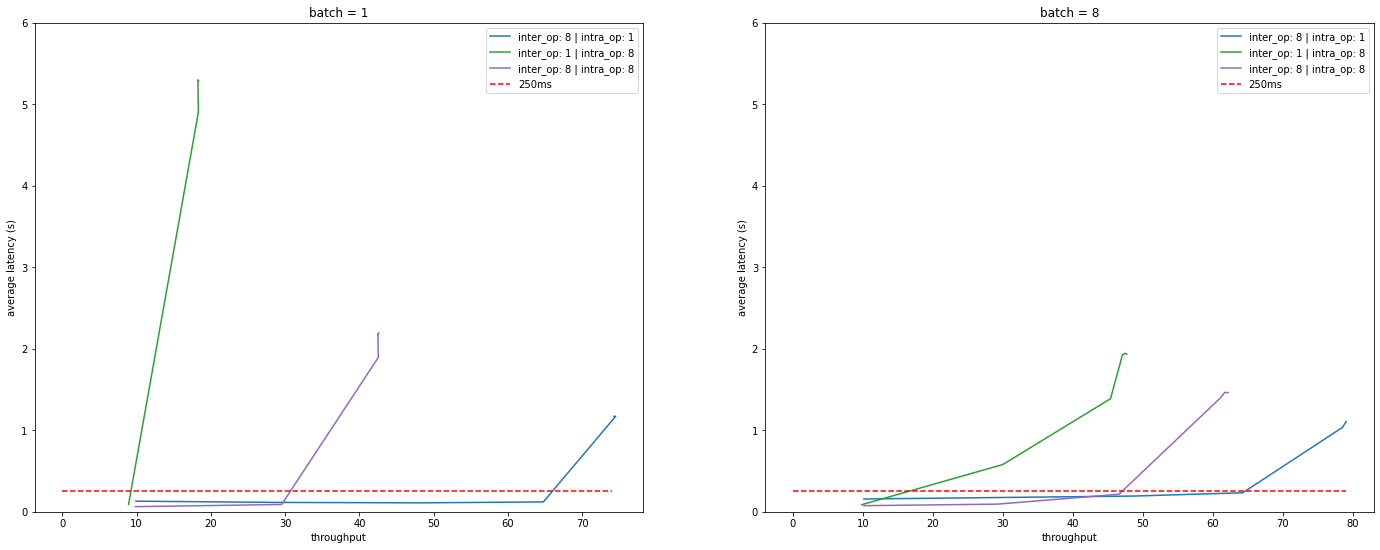

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 9))
x_keys = list(df["lambda"].unique())
print(x_keys)
x = np.arange(len(x_keys))
width = 0.2

groups_batch = list(df.groupby([ParamTypes.BATCH]))
for i, ax in enumerate(axes):
  batch, df_batch = groups_batch[i]
  groups = df_batch.groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM])
  ax.set_xlabel("throughput")
  ax.set_ylabel("average latency (s)")
  ax.set_title(f"batch = {batch}")
  ax.set_ylim(0, 6)
  max_tp = -1
  for config, group in groups:
    x_a = list(group["rate"])
    if max(x_a) > max_tp:
      max_tp = max(x_a)
    p = ax.plot(x_a, list(map(lambda x: x / 1000, group["average_latency"])), width, label=f"inter_op: {config[1]} | intra_op: {config[0]}")
  max_tp = int(max_tp) + 1
  p2 = ax.plot(list(range(max_tp)), [0.25 for _ in range(max_tp)], color="r", linestyle="dashed", label="250ms") 
  legend_without_duplicate_labels(ax)
    
# fig.tight_layout()
plt.show()
plt.close()

# For paper



In [2]:
!unzip results.zip


Archive:  results.zip
   creating: results/
  inflating: results/capacity_result_Feb_21.csv  
   creating: results/infadapter-alpha0.0125-SLO750-bursty/
  inflating: results/infadapter-alpha0.0125-SLO750-bursty/series.csv  
  inflating: results/infadapter-alpha0.0125-SLO750-bursty/whole.txt  
   creating: results/infadapter-alpha0.0125-SLO750-nonbursty/
  inflating: results/infadapter-alpha0.0125-SLO750-nonbursty/series.csv  
  inflating: results/infadapter-alpha0.0125-SLO750-nonbursty/whole.txt  
   creating: results/infadapter-alpha0.05-SLO750-bursty/
  inflating: results/infadapter-alpha0.05-SLO750-bursty/series.csv  
  inflating: results/infadapter-alpha0.05-SLO750-bursty/whole.txt  
   creating: results/infadapter-alpha0.05-SLO750-nonbursty/
  inflating: results/infadapter-alpha0.05-SLO750-nonbursty/series.csv  
  inflating: results/infadapter-alpha0.05-SLO750-nonbursty/whole.txt  
   creating: results/infadapter-alpha0.2-SLO750-bursty/
  inflating: results/infadapter-alpha0.2-SLO

In [3]:
results_path = f"results/capacity_result_Feb_21.csv"  # Every time, upload the file you want to use
df = pd.read_csv(results_path)
alpha = 0.05
baseline_accuracies = {
    18: .69758,
    34: .73314,
    50: .7613,
    101: .77374,
    152: .78312,
}
load_times = {
    18: 6.44,
    34: 6.79,
    50: 6.82,
    101: 7.77,
    152: 8.52,
}
dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES]

df = df.drop(dropping_columns, axis=1)
slas = list(df["SLA"].unique())
versions = [18, 34, 50, 101, 152]
models = {v: {} for v in versions}
for version in versions:
    for sla in slas:
        df_sla = df[df["SLA"] == sla]
        X_train = np.array(
            df_sla[(df_sla["CPU"] <= 10) & (df_sla["ARCH"] == version)]["CPU"]
        ).reshape(-1, 1)
        Y_train = df_sla[(df_sla["CPU"] <= 10) & (df_sla["ARCH"] == version)]["capacity"]

        model = LinearRegression()
        model.fit(X_train, Y_train)
        models[version][sla] = model

font = {'size': 12}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
color_list = ['#d7191c','#fdae61','#fee090','#abd9e9', '#2c7bb6']
df

,REPLICA,HARDWARE,CPU,MEM,ARCH,BATCH,NUM_BATCH_THREADS,INTRA_OP_PARALLELISM,INTER_OP_PARALLELISM,SLA,p99_latency,capacity,saturation_tp
0,1,cpu,1,1G,18,1,1,1,1,500,361.99,15,22
1,1,cpu,1,1G,18,1,1,1,1,750,389.09,19,22
2,1,cpu,1,1G,18,1,1,1,1,1000,389.09,19,22
3,1,cpu,1,1G,18,1,1,1,1,1500,703.29,21,22
4,1,cpu,1,1.25G,34,1,1,1,1,500,NaN,4,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,cpu,20,2G,101,1,20,1,20,1500,393.37,98,99
396,1,cpu,20,2.25G,152,1,20,1,20,500,391.72,64,74
397,1,cpu,20,2.25G,152,1,20,1,20,750,661.65,67,74
398,1,cpu,20,2.25G,152,1,20,1,20,1000,688.30,70,74


In [4]:
import numpy as np
from joblib import load


class Reconfiguration:
    def __init__(
        self,
        model_versions: list,
        max_cpu: int,
        df,
        baseline_accuracies: dict,
        load_times: dict,
        alpha: float,
        beta = 0.2,
    ):
        self.__max_cpu = max_cpu
        self.__model_versions = sorted(model_versions)
        self.__baseline_accuracies = baseline_accuracies
        self.__load_times = load_times
        self.__alpha = alpha
        self.__beta = beta
        self.__min_cpu = 2
        self.__sla = 750
        self.df = df
    
    def regression_model(self, model_version, cpu):
        return int(self.df[(self.df["SLA"] == self.__sla) & (self.df["ARCH"] == model_version) & (self.df["CPU"] == cpu)]["capacity"])
    
    def find_all_valid_options(self, max_cpu, rate, models=None, option=None, options=None):
        if models is None:
            models = self.__model_versions
            
        if option is None:
            option = []
        
        if options is None:
            options = []
        
        if rate <= 0:
            return option[:]
        
        for mi in range(len(models)):
            m = models[mi]
            ms = models[mi+1:]
            for c in range(self.__min_cpu, max_cpu + 1):
                p = self.find_all_valid_options(
                    max_cpu-c, rate - self.regression_model(m, c), ms, option + [(m, c)], options
                )
                if p:
                    options.append(p)
        if models == self.__model_versions:
            return options
        
    def assign_shares_to_options_models(self, options, lmbda):
        options_with_shares = []
        for option in options:
            rate = lmbda
            with_share = []
            for model_choice in sorted(option, key=lambda x: x[0], reverse=True):
                model, cpu = model_choice
                capacity = min(self.regression_model(model, cpu), rate)
                share = capacity / lmbda
                rate -= capacity
                with_share.append((model, cpu, share))
            options_with_shares.append(with_share)
        return options_with_shares

    @staticmethod
    def convert_config_to_dict(config):
        d = {}
        for ms in config:
            m, c, _ = ms
            d[m] = c
        return d
    
    def transition_cost(self, model, current_option, new_option):
        current = self.convert_config_to_dict(current_option)
        new = self.convert_config_to_dict(new_option)
        if model not in new.keys():
            return 0
        if current.get(model) != new.get(model):
            return 1
        return 0

    def load_cost(self, current_option, new_option):
        lc = {v: self.transition_cost(v, current_option, new_option) * self.__load_times[v] for v in self.__model_versions}
        return max(lc.values()) / max(self.__load_times.values())
                

    def find_best_option(self, options_with_shares, prev_option):
        # Todo: add the effect of prev_option
        max_f = -100
        best_option = None
        for option_with_shares in options_with_shares:
            accuracy = 0
            cost = 0
            for model_choice in option_with_shares:
                model, cpu, share = model_choice
                accuracy += share * self.__baseline_accuracies[model]
                cost += cpu
            load_cost = self.load_cost(prev_option, option_with_shares)
            resource_cost = cost / self.__max_cpu
            f = accuracy - (self.__alpha * resource_cost + self.__beta * load_cost)
            if f > max_f:
                max_f = f
                best_option = option_with_shares
        return best_option
    
    def reconfig(self, lmbda, current_option):
        max_cpu = self.__max_cpu
        mamv = sorted(self.__model_versions)[-1]
        for cpu in range(self.__min_cpu, max_cpu + 1):
            if self.regression_model(mamv, cpu) >= lmbda:
                max_cpu = cpu
                break
        # print("max_cpu", max_cpu)
        all_options = self.find_all_valid_options(max_cpu, lmbda)
        all_options_with_shares = self.assign_shares_to_options_models(all_options, lmbda)
        # print("len", len(all_options_with_shares))
        best_option = self.find_best_option(all_options_with_shares, current_option)
        return best_option
    
    def reconfig_msp(self, lmbda, current_option):
        max_cpu = self.__max_cpu
        mamv = sorted(self.__model_versions)[-1]
        for cpu in range(self.__min_cpu, max_cpu + 1):
            if self.regression_model(mamv, cpu) >= lmbda:
                max_cpu = cpu
                break
        all_options = []
        for mv in self.__model_versions:
            for c in range(2, max_cpu + 1):
                if self.regression_model(mv, c) >= lmbda:
                    all_options.append([(mv, c, 1)])
                    break
        best_options = self.find_best_option(all_options, current_option)
        return best_options


[0 1 2] [190, 78, 27]
[0 1 2] [344, 145, 49]
[0 1 2] [473, 200, 67]


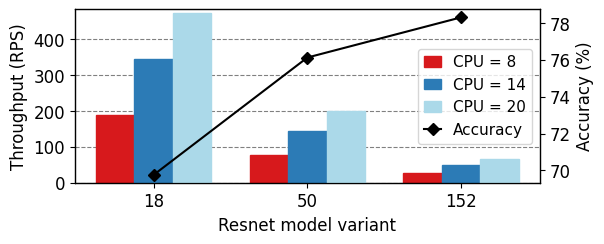

In [5]:
r = Reconfiguration(versions, None, df, baseline_accuracies, load_times, alpha=0, beta=0.0)
fig, ax = plt.subplots(figsize=(6, 2.25))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()
width = 0.25
sla = 750

x_keys = [18, 50, 152]
costs = [8, 14, 20]

values = []
ax.set_xlabel("Resnet model variant")
ax.set_ylabel("Throughput (RPS)")
ax4.set_ylabel("Accuracy (%)")
values = [[r.regression_model(v, cost) for v in x_keys] for cost in costs]

values4 = [baseline_accuracies[v] * 100 for v in x_keys]

x_len = len(values)
x = np.arange(x_len)

ax.set_xticks(x)
ax.set_xticklabels(x_keys)
print(x, values[0])
print(x, values[1])
print(x, values[2])
bars = ax.bar(x-width, values[0], width)
bars2 = ax2.bar(x, values[1], width)
bars3 = ax3.bar(x+width, values[2], width)
ax.set_axisbelow(True)
ax.grid(axis='y', color="gray", linestyle='dashed')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color="gray", linestyle='dashed')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color="gray", linestyle='dashed')
acc_plot = ax4.plot(np.arange(x_len), values4, color="black", marker="D", label="Accuracy")

for i in range(len(bars)):
  color = color_list[0]
  bars[i].set_color(color)

for i in range(len(bars)):
  color = color_list[-1]
  bars2[i].set_color(color)

for i in range(len(bars)):
  color = color_list[-2]
  bars3[i].set_color(color)
  
patches = []
for i in range(len(costs)):
  patches.append(mpatches.Patch(color=color_list[-i], label=f'CPU = {costs[i]}'))

plt.legend(handles=[*patches, acc_plot[0]], loc="right", handlelength=1.1, fontsize=11)

ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(True)
ax.set_ylim([0, max(values[-1]) + 10])
ax2.set_ylim([0, max(values[-1]) + 10])
ax3.set_ylim([0, max(values[-1]) + 10])

plt.savefig('variant-cpu.pdf', dpi=600, format='pdf', bbox_inches = 'tight',  pad_inches = 0)

infadapter 8 [(101, 2, 0.136986301369863), (50, 6, 0.863013698630137)]
msp 8 [(50, 8, 1)]
infadapter 14 [(152, 6, 0.3424657534246575), (101, 6, 0.4246575342465753), (50, 2, 0.2328767123287671)]
msp 14 [(50, 8, 1)]
infadapter 20 [(152, 16, 0.8082191780821918), (101, 3, 0.1917808219178082)]
msp 20 [(101, 15, 1)]


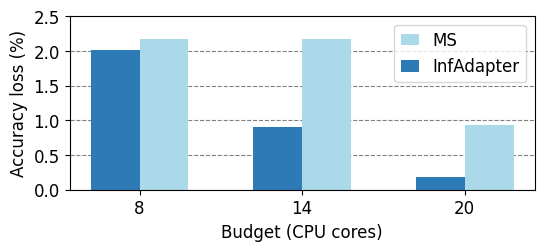

In [6]:
def get_cost_acc(opt):
    accuracy = 0
    cost = 0
    for model_choice in opt:
        model, cpu, share = model_choice
        accuracy += share * baseline_accuracies[model]
        cost += cpu
    return cost, accuracy
  
budgets = {}
budgets_msp = {}

lmbda = 73
budget_list = [8, 14, 20]
base_acc = baseline_accuracies[152]
for budget in budget_list:
    r = Reconfiguration(versions, budget, df, baseline_accuracies, load_times, alpha=0, beta=0.0)
    config = r.reconfig(lmbda, [(18, 1, 1)])
    cost, acc = get_cost_acc(config)
    print("infadapter", budget, config)
    budgets[budget] = base_acc * 100 - acc * 100
    
    config = r.reconfig_msp(lmbda, [(18, 1, 1)])
    cost, acc = get_cost_acc(config)
    print("msp", budget, config)
    budgets_msp[budget] = base_acc * 100 - acc * 100

x = np.arange(len(budget_list))
fig, ax = plt.subplots(figsize=(6, 2.25))
width = 0.3

ax.set_xticks(x)
ax.set_xticklabels(list(budgets.keys()))
ax.set_ylim([0, 2.5])
ax.bar(x + width/2, list(budgets_msp.values()), width, label=f"MS", color=color_list[-2])
ax.bar(x - width/2, list(budgets.values()), width, label=f"InfAdapter", color=color_list[-1])
ax.set_axisbelow(True)
ax.grid(axis='y', color="gray", linestyle='dashed')

mn = baseline_accuracies[18] * 100
mx = baseline_accuracies[152] * 100 - mn
# ax.set_ylim([0, mx])

ax.set_xlabel("Budget (CPU cores)")
ax.set_ylabel("Accuracy loss (%)")
plt.legend(handlelength=1.1, fontsize=12)
# fig.tight_layout()
plt.savefig('infadapter-msp-accuracy-loss.pdf', dpi=600, format='pdf', bbox_inches = 'tight',  pad_inches = 0)


In [7]:
INFADAPTER = "InfAdapter"
MSPLUS = "MS+"
VPA18 = "VPA-18"
VPA34 = "VPA-34"
VPA50 = "VPA-50"
VPA101 = "VPA-101"
VPA152 = "VPA-152"

colors = {
    INFADAPTER: color_list[-1],
    MSPLUS: color_list[-2],
    VPA18: color_list[1],
    VPA50: color_list[2],
    VPA152: color_list[0]
}

markers = {
    INFADAPTER: ".", 
    MSPLUS: None,
    VPA18: None,
    VPA34: None,
    VPA50: None,
    VPA101: None,
    VPA152: None,
}

In [8]:
!unzip lstm_saved_model.zip

Archive:  lstm_saved_model.zip
   creating: lstm_saved_model/
   creating: lstm_saved_model/assets/
  inflating: lstm_saved_model/fingerprint.pb  
  inflating: lstm_saved_model/saved_model.pb  
   creating: lstm_saved_model/variables/
  inflating: lstm_saved_model/variables/variables.data-00000-of-00001  
  inflating: lstm_saved_model/variables/variables.index  
  inflating: lstm_saved_model/keras_metadata.pb  


In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
tf.random.set_seed(7)

2023-04-20 23:23:07.756972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 23:23:07.864257: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 23:23:07.869656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 23:23:07.869668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

**LSTM**
--

In [16]:
lstm_model = load_model(f"./lstm_saved_model")

def get_x_y(data):
    x = []
    y = []
    for i in range(10):
      data.insert(0, data[0])
    for i in range(0, len(data) - 10):
      x.extend(data[i:i+10])
      y.append(data[i+10])
    x = np.array(x)
    print('shapes')
    print(x.shape)
    print(len(y))
    return tf.convert_to_tensor(x.reshape((-1, 10, 1)), dtype=tf.float32), y

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [23]:
def plot_for_alpha(alpha, wl_type):
  filenames = {
      INFADAPTER: f"results/infadapter-alpha{alpha}-SLO750-{wl_type}", 
      MSPLUS: f"results/msp-alpha{alpha}-SLO750-{wl_type}",
      VPA18: f"results/vpa-18-{wl_type}",
      VPA34: f"results/vpa-34-{wl_type}",
      VPA50: f"results/vpa-50-{wl_type}",
      VPA101: f"results/vpa-101-{wl_type}",
      VPA152: f"results/vpa-152-{wl_type}",
  }

  dfs = {}

  for exp, fn in filenames.items():
      dfs[exp] = pd.read_csv(f"{fn}/series.csv")


  x_len = len(list(dfs.values())[0]["accuracy"])
  print("len x", x_len)

  fig, axs = plt.subplots(4, 1, figsize=(6, 9))
  axs_idx = 0
  for metric in ["rate", "99", "accuracy", "cost"]:
      ax = axs[axs_idx]
      ax.grid(axis='y', linestyle='dashed', color="gray")
      axs_idx += 1
      if metric == "99":
          ax.plot(list(range(x_len)), [0.75 for _ in range(x_len)], linestyle="dashed", label="750 ms", color="green")
          ylabel = "P99-Latency (s)"
          ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
          ax.set_ylim([0, 2.5])
      elif metric == "accuracy":
          ylabel = "Accuracy loss (%)terate "
          ax.set_ylim([-0.5, 10])
          ax.set_yticks([0, 2, 4, 6, 8, 10])
      elif metric == "rate":
          ylabel = "Workload (RPS)"
          ax.set_ylim([0, 250])
          ax.set_yticks([0, 50, 100, 150, 200, 250])
      else:
          ylabel = "Cost (CPU cores)"
          ax.set_ylim([0, 22])
          ax.set_yticks([0, 5, 10, 15, 20])
      
      for exp, df in dfs.items():
          if exp not in [INFADAPTER, VPA18, MSPLUS, VPA152, VPA50]:
              continue
          metric_values = df[metric]
          if metric == "accuracy":
            metric_values = (baseline_accuracies[152] - metric_values) * 100
                      
          marker = markers[exp]
          if metric in ["99", "rate"]:
              marker = None
          if metric != "rate":
            ax.plot(list(range(len(metric_values))), metric_values, label=exp, marker=marker, color=colors[exp])
          else:
            # x, y = get_x_y(list(df["rate"]))
            # print(len(y), len(df["rate"]))
            # pred_y = list(lstm_model.predict(x))
            # print(len(pred_y), "pred_y")
            ax.plot(list(range(len(metric_values))), metric_values, label="real", marker=marker, color="dimgray")
            # ax.plot(list(range(len(metric_values))), pred_y, label="prediction", marker=None, color="lightgray")
            ax.legend()
            break
      
      fig.canvas.draw()
      # labels = [item.get_text() for item in ax.get_xticklabels()]
      # labels[0] = "-" + labels[0][1:]
      # labels = list(map(lambda x: int(x) * 5, labels))
      
      ax.set_ylabel(ylabel)
      if axs_idx < 4:
          labels = []
          ax.set_xticklabels([])
      else:
          ax.set_xlabel("Time (s)")
      ax.set_xlim([-5, 245])
      ax.set_xticks([i for i in range(0, 245, 40)], [i for i in range(0, 1201 , 200)])
        
  plt.legend(fontsize=12, fancybox=False, ncol=5, frameon=False, bbox_to_anchor=(1.02,4.9), handlelength=0.6, columnspacing=0.6)
  fig.tight_layout()
  fig.savefig(f"comparison-{alpha}-{wl_type}.pdf", dpi=600, format='pdf', bbox_inches = 'tight', pad_inches = 0)


alpha = 0.2
--

len x 242


/tmp/ipykernel_3869898/819266107.py:82: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


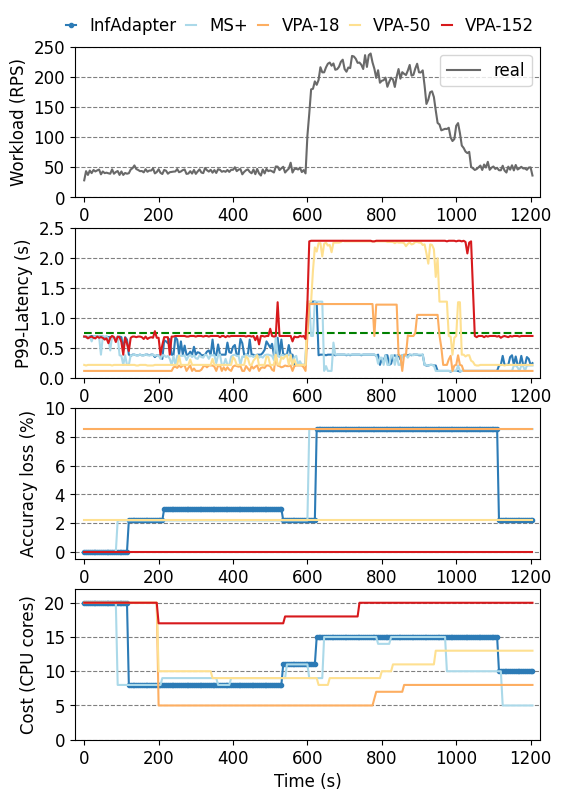

In [24]:
plot_for_alpha(0.2, "bursty")

alpha = 0.05
--

len x 242
shapes
(2420,)
242
242 242
8/8 [==============================] - 0s 5ms/step
242 pred_y


<ipython-input-20-6fe9f4c8bf84>:82: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


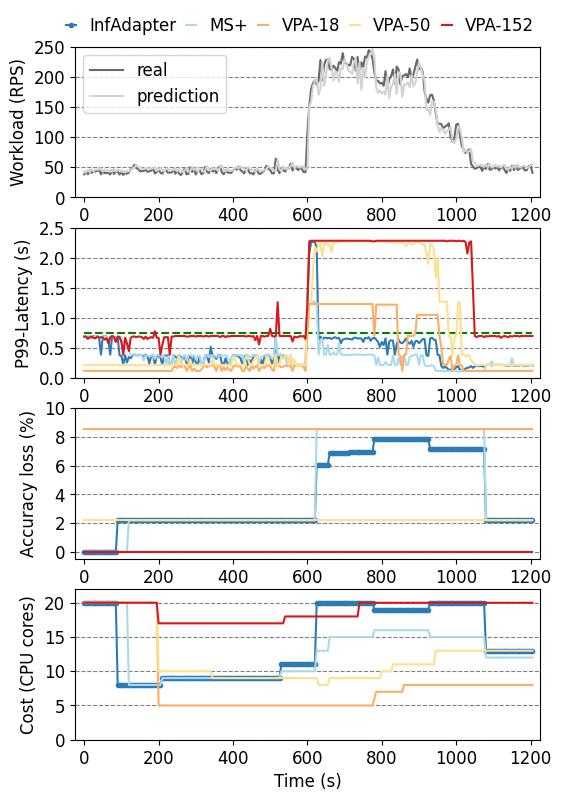

In [ ]:
plot_for_alpha(0.05, "bursty")

alpha = 0.0125
--

len x 242
shapes
(2420,)
242
242 242
8/8 [==============================] - 0s 4ms/step
242 pred_y


<ipython-input-20-6fe9f4c8bf84>:82: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


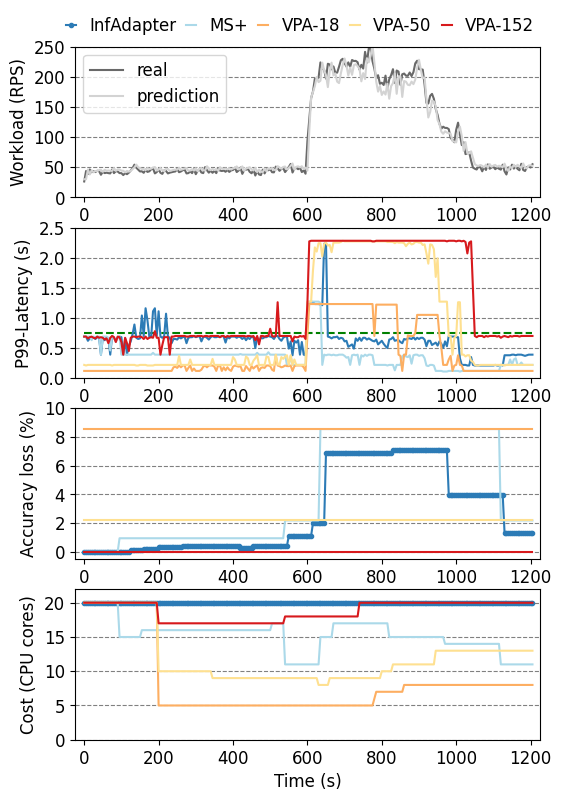

In [ ]:
plot_for_alpha(0.0125, "bursty")

In [ ]:
def plog_agg(wl_type):

  filenames_0125 = {
      INFADAPTER: f"results/infadapter-alpha0.0125-SLO750-{wl_type}", 
      MSPLUS: f"results/msp-alpha0.0125-SLO750-{wl_type}",
      VPA18: f"results/vpa-18-{wl_type}",
      VPA34: f"results/vpa-34-{wl_type}",
      VPA50: f"results/vpa-50-{wl_type}",
      VPA101: f"results/vpa-101-{wl_type}",
      VPA152: f"results/vpa-152-{wl_type}",
  }
  filenames_05 = {
      INFADAPTER: f"results/infadapter-alpha0.05-SLO750-{wl_type}", 
      MSPLUS: f"results/msp-alpha0.05-SLO750-{wl_type}",
      VPA18: f"results/vpa-18-{wl_type}",
      VPA34: f"results/vpa-34-{wl_type}",
      VPA50: f"results/vpa-50-{wl_type}",
      VPA101: f"results/vpa-101-{wl_type}",
      VPA152: f"results/vpa-152-{wl_type}",
  }
  filenames_2 = {
      INFADAPTER: f"results/infadapter-alpha0.2-SLO750-{wl_type}", 
      MSPLUS: f"results/msp-alpha0.2-SLO750-{wl_type}",
      VPA18: f"results/vpa-18-{wl_type}",
      VPA34: f"results/vpa-34-{wl_type}",
      VPA50: f"results/vpa-50-{wl_type}",
      VPA101: f"results/vpa-101-{wl_type}",
      VPA152: f"results/vpa-152-{wl_type}",
  }
  dfs_0125 = {}
  dfs_05 = {}
  dfs_2 = {}
  for exp, fn in filenames_0125.items():
      dfs_0125[exp] = pd.read_csv(f"{fn}/series.csv")
  for exp, fn in filenames_05.items():
      if exp not in [INFADAPTER, MSPLUS]:
        dfs_05[exp] = dfs_0125[exp]
      else:
        dfs_05[exp] = pd.read_csv(f"{fn}/series.csv")
  for exp, fn in filenames_2.items():
      if exp not in [MSPLUS, INFADAPTER]:
        dfs_2[exp] = dfs_0125[exp]
      else:
        dfs_2[exp] = pd.read_csv(f"{fn}/series.csv")
  total_requests = 121697
  if wl_type == "bursty":
    total_results = {
        VPA18: {"accuracy": [0.6976] * 3, "cost": [8.49] * 3},
        VPA34: {"accuracy": [0.7331] * 3, "cost": [11.18] * 3},
        VPA50: {"accuracy": [0.7613] * 3, "cost": [12.02] * 3},
        VPA101: {"accuracy": [0.7737] * 3, "cost": [15.91] * 3},
        VPA152: {"accuracy": [0.7831] * 3, "cost": [18.83] * 3},
        INFADAPTER: {
            "accuracy": [0.7354, 0.7439, 0.7559],
            "cost": [12.44, 14.34, 20.0]
        },
        MSPLUS: {
            "accuracy": [0.7313, 0.7395, 0.7421],
            "cost": [11.3, 12.75, 15.26]
        },
    }
  else:
    total_results = {
        VPA18: {"accuracy": [0.6976] * 3, "cost": [12.27] * 3},
        VPA34: {"accuracy": [0.7331] * 3, "cost": [20.0] * 3},
        VPA50: {"accuracy": [0.7613] * 3, "cost": [18.57] * 3},
        VPA101: {"accuracy": [0.7737] * 3, "cost": [15.91] * 3},
        VPA152: {"accuracy": [0.7831] * 3, "cost": [18.83] * 3},
        INFADAPTER: {
            "accuracy": [0.7354911580594673, 0.7439543818466351, 0.755932942097027],
            "cost": [12.44, 14.34, 20.0]
        },
        MSPLUS: {
            "accuracy": [0.7313879499217525, 0.7395086922474541, 0.742177055599061],
            "cost": [11.3, 12.75, 15.26]
        },
    }

  percentile_list = [99, 98, 97, 96, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 40, 30, 20, 10]
  rates_5s = list(dfs_2[INFADAPTER]["rate"])
 
  violations = {}
  # timeouts = {}  # Dropped by tfserving queue manager
  percentiles = {}
  for p in percentile_list:
      percentiles[p] = {}
      for exp in dfs_2.keys():
        percentiles[p][exp] = {}
  for beta in [0.2, 0.05, 0.0125]:
    if beta == 0.2:
      dfs = dfs_2
    elif beta == 0.05:
      dfs = dfs_05
    else:
      dfs = dfs_0125

    for exp in dfs.keys():
        df = dfs[exp]
        # timeouts[exp] = {}
        violations[exp] = {}
        for p in percentile_list:
            percentiles[p][exp][beta] = list(df[f"{p}"])
  
  for beta in [0.2, 0.05, 0.0125]:
    total = 0
    for i in range(len(rates_5s)):
        total += rates_5s[i] * 5
        for exp in dfs.keys():
            if violations[exp].get(beta) is None:
              violations[exp][beta] = 0
            found = False
            for p in percentile_list:
                ps = percentiles[p][exp][beta]
                if math.isnan(ps[i]):
                    found = False
                    break
                if ps[i] < 0.75:
                    found = True
                    violations[exp][beta] += (99 - p) * rates_5s[i] * 5 / 100
                    break
            if found is False:
                violations[exp][beta] += 0.99 * rates_5s[i] * 5
      
    for exp in violations.keys():
        diff = total_requests - total
        violations[exp][beta] = 100 * violations[exp][beta] / total
        # timeouts[exp].append(
        #     100 * (total - (total_results[exp]["successful_requests"] - diff))
        #     / total
        # )

  print("violations", violations)
  # print("timeouts", timeouts)

  aggregated = {}
  for exp in violations.keys():
      if aggregated.get(exp) is None:
          aggregated[exp] = {}
      aggregated[exp] = {
          "success": {k: 100 - v for k, v in violations[exp].items()},
          "violations": violations[exp],
          # "dropped": timeouts[exp],
          "cost": total_results[exp]["cost"],
          "accuracy": total_results[exp]["accuracy"]
      }
      
  print(aggregated)


  fig, axs = plt.subplots(3, 1, figsize=(6, 6.75))
  axs_idx = 0
  for metric in ["accuracy", "cost", "violation"]:
      cc = []
      ax = axs[axs_idx]
      ax.set_axisbelow(True)
      ax.grid(axis='y', color="gray", linestyle='dashed')
      axs_idx += 1
      if metric == "violation":
          ylabel = "SLO violation (%)"
      elif metric == "accuracy":
          ylabel = "Accuracy loss (%)"
      else:
          ylabel = "Cost (CPU cores)"
          ax.set_ylim([0, 20])
          # ax.legend()
      
      x = np.arange(3) # number of betas
      bars = []
      violation_bars = {"success": [], "violation": []}
      width = 0.15
      multiplier = -2
      for exp, df in dfs.items():
          
          if exp not in [INFADAPTER, VPA18, VPA50, VPA152, MSPLUS]:
              continue
          cc.append(colors[exp])
          if metric == "violation":
            violation_bars["success"] = list(aggregated[exp]["success"].values())
            violation_bars["violation"] = list(aggregated[exp]["violations"].values())
            bottom = np.zeros(3)
            offset = width * multiplier
            # for stack in violation_bars.keys():
              # kwargs = {}
              # if stack == "violation":
              #   kwargs["edgecolor"] = "black"
              #   kwargs["color"] = "grey"
              #   kwargs["hatch"] = "X"
              #   if exp == VPA152:
              #     kwargs["label"] = "violation"
              # else:
              #   kwargs["color"] = colors[exp]
              #   kwargs["label"] = exp
            bar_plots = ax.bar(x + offset, violation_bars["violation"], width, bottom=bottom, label=exp, color=colors[exp])
              # bottom += np.array(violation_bars[stack])
          elif metric == "accuracy":
            acc = aggregated[exp][metric]
            bars = [(baseline_accuracies[152] -  acc_i) * 100 for acc_i in acc]
            for i in range(len(bars)):
              if bars[i] < 0.01:
                bars[i] = 0.1
            offset = width * multiplier
            bar_plots = ax.bar(x + offset, bars, width, color=colors[exp], label=exp)
          else:
            bars = aggregated[exp][metric]
            offset = width * multiplier
            bar_plots = ax.bar(x + offset, bars, width, color=colors[exp], label=exp)
          multiplier += 1
      
      fig.canvas.draw()
      
      ax.set_ylabel(ylabel)
      if axs_idx < 3:
          labels = []
      else:
        labels = ["\u03B2=0.2", "\u03B2=0.05", "\u03B2=0.0125"]
      ax.set_xticks(x, labels)
  # ax.legend(loc="lower left")
  plt.legend(fontsize=13, fancybox=False, ncol=3, frameon=False, bbox_to_anchor=(0.93,3.88), handlelength=1, columnspacing=0.8)
  fig.tight_layout()
  fig.savefig(f"comparison-agg-{wl_type}.pdf", dpi=600, format='pdf', bbox_inches = 'tight', pad_inches = 0)


Aggregated fig
--

violations {'InfAdapter': {0.2: 0.0, 0.05: 0.005668363112244969, 0.0125: 0.0031735781032786762}, 'MS+': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'VPA-18': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'VPA-34': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'VPA-50': {0.2: 31.19812400912297, 0.05: 31.19812400912297, 0.0125: 31.19812400912297}, 'VPA-101': {0.2: 69.75989247578873, 0.05: 69.75989247578873, 0.0125: 69.75989247578873}, 'VPA-152': {0.2: 82.88490351499202, 0.05: 82.88490351499202, 0.0125: 82.88490351499202}}
{'InfAdapter': {'success': {0.2: 100.0, 0.05: 99.99433163688775, 0.0125: 99.99682642189673}, 'violations': {0.2: 0.0, 0.05: 0.005668363112244969, 0.0125: 0.0031735781032786762}, 'cost': [12.44, 14.34, 20.0], 'accuracy': [0.7354911580594673, 0.7439543818466351, 0.755932942097027]}, 'MS+': {'success': {0.2: 100.0, 0.05: 100.0, 0.0125: 100.0}, 'violations': {0.2: 0.0, 0.05: 0.0, 0.0125: 0.0}, 'cost': [11.3, 12.75, 15.26], 'accuracy': [0.7313879499217525, 0.7395086922474541, 0.742177055599061]}, 'VPA-

<ipython-input-33-38dc08f42e9f>:219: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


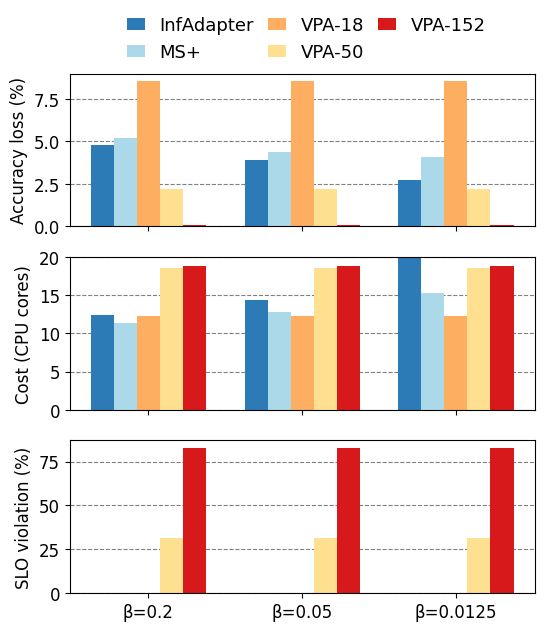

In [ ]:
plog_agg("nonbursty")

<ipython-input-40-72693b4440e1>:14: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  groups_batch = list(


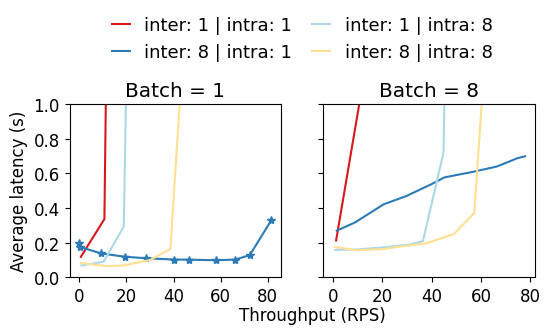

In [ ]:
from tensorflow.python.util.dispatch import dispatch_for_types
results_path = f"throughput_result_Mar_10.csv"  # Every time, upload the file you want to use
dfy = pd.read_csv(results_path)

dropping_columns = ["timestamp", ParamTypes.MAX_ENQUEUED_BATCHES]

dfy = dfy.drop(dropping_columns, axis=1)
fig, axes = plt.subplots(1, 2, figsize=(6, 2.25))

x_keys = list(dfy["lambda"].unique())
x = np.arange(len(x_keys))
width = 0.2

groups_batch = list(
    dfy[
        (dfy['ARCH'] == 50) &
        ((dfy['NUM_BATCH_THREADS'] == dfy['CPU']) | (dfy['BATCH'] == 1)) &
        (dfy['BATCH'] != 4) &      
        (dfy['lambda'] < 100)
    ].groupby([ParamTypes.BATCH])
)
c = 0
for i, ax in enumerate(axes):
  batch, df_batch = groups_batch[i]
  groups = df_batch.groupby([ParamTypes.INTRA_OP_PARALLELISM, ParamTypes.INTER_OP_PARALLELISM])
  # ax.set_xticks(x)
  # ax.set_xticklabels(x_keys)
  # ax.set_xlabel("Throughput (RPS)")
  ax.set_title(f"Batch = {batch}")
  if c == 0:
    ax.set_ylabel("Average latency (s)")
    c += 1
  else:
    ax.set_yticklabels([])
  ci = 0
  for config, group in groups:
    
    ax.set_ylim(0, 1)
    x_a = list(group["rate"])
    y = list(map(lambda x: min(x / 1000, 1.5), group["average_latency"]))
    kwargs = {}
    if config[1] == 8 and config[0] == 1 and batch == 1:
      kwargs["marker"] = "*"
    p1 = ax.plot(x_a, y, width, label=f"inter: {config[1]} | intra: {config[0]}", color=color_list[-ci], **kwargs)
    # ax.arrow(
    #     x_a[-1],
    #     y[-1],
    #     0.1,
    #     0.2,
    #     shape='full', 
    #     lw=0, 
    #     head_width=0.1,
    #     color=colors[ci]
    # )
    ci = (ci + 1) % 4
    ax.set_xticks(list(range(0,81,20)))

    ax.set_xticklabels(list(range(0,81,20)))

# legend_without_duplicate_labels(ax)
# plt.legend(fontsize=13, fancybox=False, ncol=3, frameon=False, bbox_to_anchor=(0.93,3.88), handlelength=1, columnspacing=0.8)
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]

plt.legend(
  *zip(*unique),
  loc="upper center",
  fontsize=13,
  fancybox=False, 
  ncol=2,
  frameon=False,
  bbox_to_anchor=(-0.1,1.6), 
  handlelength=1,
  columnspacing=1.1
)
# fig.tight_layout()
fig.text(0.53, -0.08, 'Throughput (RPS)', ha='center')
fig.savefig('paralellism-batch-saturation.pdf', dpi=600, format='pdf', bbox_inches = 'tight',  pad_inches = 0)


for load 100 {18: 5, 34: 9, 50: 11, 101: 20}
for load 200 {18: 9, 34: 15, 50: 20}
13 0.7668733999999999
20 0.7749594000000001
25 0.780943800664976
40 0.824365695833712


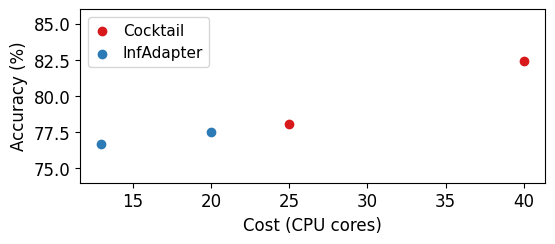

In [ ]:
# compare with cocktail
r = r_05 = Reconfiguration(versions, 20, df, baseline_accuracies, load_times, alpha=0.05, beta=0.0)
r_0125 = Reconfiguration(versions, 20, df, baseline_accuracies, load_times, alpha=0.0125, beta=0.0)

load_100_cpus = {}
load_200_cpus = {}

for v in versions:
  c = 1
  while c <= 20:
    if r.regression_model(v, c) >= 98:
      load_100_cpus[v] = c
      break
    c += 1

for v in versions:
  c = 1
  while c <= 20:
    if r.regression_model(v, c) >= 200:
      load_200_cpus[v] = c
      break
    c += 1
  
print("for load 100", load_100_cpus)
print("for load 200", load_200_cpus)


N = 3

acc_18 = baseline_accuracies[18]
acc_34 = baseline_accuracies[34]
ens_acc_1 = 0
ens_acc_2 = 0
ens_cost_1 = load_100_cpus[18] + load_100_cpus[34] + load_100_cpus[50]
ens_cost_2 = load_100_cpus[34] + load_100_cpus[50] + load_100_cpus[101]

for i in range(N//2+1, N+1):
  ens_acc_1 += math.comb(N, i) * (acc_18 ** i) * ((1-acc_18) ** (N-i))
  ens_acc_2 += math.comb(N, i) * (acc_34 ** i) * ((1-acc_34) ** (N-i))

config_05 = r_05.reconfig(100, [(18, 1, 1)])
config_0125 = r_0125.reconfig(100, [(18, 1, 1)])

inf_acc_05 = 0
inf_cost_05 = 0
inf_acc_0125 = 0
inf_cost_0125 = 0
for tup in config_05:
  m, n, s = tup
  inf_acc_05 += baseline_accuracies[m] * s
  inf_cost_05 += n

for tup in config_0125:
  m, n, s = tup
  inf_acc_0125 += baseline_accuracies[m] * s
  inf_cost_0125 += n


print(inf_cost_05, inf_acc_05)
print(inf_cost_0125, inf_acc_0125)
print(ens_cost_1, ens_acc_1)
print(ens_cost_2, ens_acc_2)
fig, ax = plt.subplots(figsize=(6, 2.25))
ax.scatter([ens_cost_1, ens_cost_2], [ens_acc_1 * 100, ens_acc_2 * 100], label="Cocktail", color=list(colors.values())[-1])
ax.scatter([inf_cost_05, inf_cost_0125], [inf_acc_05 * 100, inf_acc_0125 * 100], label="InfAdapter", color=colors[INFADAPTER])
ax.set_xlabel("Cost (CPU cores)")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim([74, 86])
plt.legend(handlelength=1.1, fontsize=11)
# fig.tight_layout()
fig.savefig('cocktail_comparison_100rps.pdf', dpi=600, format='pdf', bbox_inches = 'tight',  pad_inches = 0)


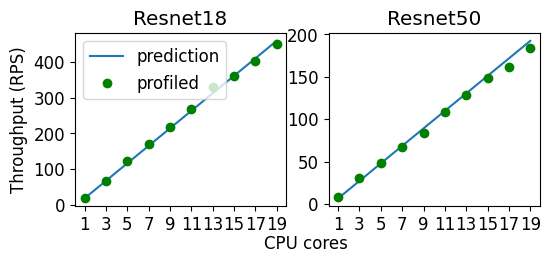

In [ ]:
from sklearn.linear_model import LinearRegression

dfx = pd.read_csv(f"results/capacity_result_Feb_21.csv")

sla = 750

versions = [18, 34, 50, 101, 152]
models = {v: {} for v in versions}
for version in versions:
    df_sla = dfx[dfx["SLA"] == sla]
    df_sla = df_sla.query("CPU in (1,2,4,8,16)")
    X_train = np.array(df_sla[(df_sla["ARCH"] == version)]["CPU"]).reshape(-1, 1)
    Y_train = df_sla[(df_sla["ARCH"] == version)]["capacity"]

    model = LinearRegression()
    model.fit(X_train, Y_train)
    models[version][sla] = model

fig, axes = plt.subplots(1, 2, figsize=(6, 2.25))
idx = 0
for version in [18, 50]:
    ax = axes[idx]
    model = models[version][sla]
    df_sla = df[df["SLA"] == sla]
    X_test = np.array(df_sla[df_sla["ARCH"] == version]["CPU"]).reshape(-1, 1)

    y_pred = model.predict(X_test)
    ax.set_title(f"Resnet{version}")
    ax.plot(list(range(1, 21, 2)), y_pred[::2], label="prediction")
    ax.plot(list(range(1, 21, 2)), df_sla[df_sla["ARCH"] == version]["capacity"][::2], "go", label="profiled")
    
    ax.set_xticks(list(range(1, 21, 2)))
    if idx == 0:
      ax.set_ylabel("Throughput (RPS)")
      ax.legend()
    idx += 1

fig.text(0.51, -0.08, 'CPU cores', ha='center')
# fig.tight_layout()
fig.savefig('linear-regression-accuracy.pdf', dpi=600, format='pdf', bbox_inches = 'tight',  pad_inches = 0)